# Functions & Reusable Code

In [1]:
##############################
# NOTE: This will fail for large dataset processing or complex model evaluation
# Use the command below to run it in the background 
##############################
# Source: https://www.maksimeren.com/post/screen-and-jupyter-a-way-to-run-long-notebooks-headless/
# jupyter nbconvert --to notebook --execute prompt_III.template.ipynb --output=prompt_III.out.ipynb --ExecutePreprocessor.timeout=-1

##############################
# Library Imports
##############################
import copy
import json
import itertools
import math
import os
import io
from datetime import datetime
from random import randint
import timeit
import datetime

from IPython.core.getipython import get_ipython
from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Frameworks
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import seaborn.objects as so


# Plotly
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# scikit-learn
from sklearn import metrics
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFE

##############################
# Needed methods to bootstrap
##############################
def readFile(path):
    with open(path) as f: 
        data = f.read()
    return data

def readJson(path):
    data = readFile(path)
    return json.loads(data)

##############################
# Configuration + Flow control
##############################
BEGIN_RUN_DATETIME = datetime.datetime.now()
SETTINGS = readJson('./settings.json')
EXECUTION_MODE = SETTINGS['mode']
DEV_MODE = "development" == EXECUTION_MODE
print(f'Execution mode: {DEV_MODE}')
USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY = True
EXECUTION_START_TIME = timeit.default_timer()
RUNTIME_METRICS = {}

##############################
# Runtime Settings
##############################
set_config(display="diagram")
import warnings
warnings.filterwarnings('ignore')

##############################
# Constants
##############################
# https://seaborn.pydata.org/tutorial/color_palettes.html#sequential-color-palettes
MAIN_PALETTE_QUALITATIVE = 'pastel'
HIGHLIGHT_PALETTE_QUALITATIVE = 'Pastel2'
MAIN_PALETTE_SEQUENTIAL = 'crest'
IMAGE_DIR_SUFFIX = ''
INPUT_FILE = './data/bank-additional-full.csv'
RESULT_DIR = f'./analysis_results'    
README_FILE = f'./README.md'

CONFIG_NODE_KEY = 'config'
DEFAULT_GRID_SEARCH_SCORING_TYPES = ['accuracy']
BASELINE_MODEL_2_TRY = {
    'Baseline (DummyClassifier)': {
        'model': DummyClassifier(random_state=42),
        'params': {
            'model__strategy': ['most_frequent']
        }
    }
}
SIMPLE_MODEL_2_TRY = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
        }
    }
}
DEFAULT_MODELS_2_TRY = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {}
    }
}        
GRID_SEARCH_MODELS_2_TRY = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': range(1, 75, 1),
            'model__weights': ['uniform', 'distance']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'model__penalty': ['l2', 'elasticnet'],
            'model__C': np.linspace(0.1, 1, num=10)
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': range(1, 11),
            'model__criterion': ['gini', 'entropy', 'log_loss']
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'model__C': np.linspace(0.1, 1, num=10)
        }
    }
}
if DEV_MODE:
    RESULT_DIR =  f'{RESULT_DIR}.{EXECUTION_MODE}'
    INPUT_FILE = './data/bank-additional.csv'
    README_FILE = f'./README.{EXECUTION_MODE}.md'
    GRID_SEARCH_MODELS_2_TRY['KNN']['params'] = {
        'model__n_neighbors': [5]
    }
    GRID_SEARCH_MODELS_2_TRY['Logistic Regression']['params'] = {
        'model__penalty': ['l2']
    }
    GRID_SEARCH_MODELS_2_TRY['Decision Tree']['params'] = {
        'model__max_depth': [5],
        'model__criterion': ['log_loss']
    }
    GRID_SEARCH_MODELS_2_TRY['SVC']['params'] = {
        'model__kernel': ['linear']
    }

RESULT_FILE_PREFIX = RESULT_DIR +'/module_17_01.'
IMAGE_PREFIX = RESULT_FILE_PREFIX

IGNORE_FEATURES = {}

STEP03_PREFIX = 'step03.data_understanding.'
STEP05_PREFIX = 'step05.engineering_features.'
STEP07_PREFIX = 'step07.baseline_model.'
STEP08_PREFIX = 'step08.simple_model.'
STEP09_PREFIX = 'step09.score_model.'
STEP10_PREFIX = 'step10.model_comparison.'
STEP11_PREFIX = 'step11.improving_model.'
STEP12_PREFIX = 'step12.final_analysis.'

FEATURES_BANK_CLIENT_DATA = [
    'age', 
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'duration'
]
FEATURES_OTHER = [
    'campaign',
    'pdays',
    'previous',
    'poutcome'
]
FEATURES_SOCIAL_ECONOMIC = [
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]
TARGET_FIELD = 'y'


EXPERIMENT1_FEATURES = FEATURES_BANK_CLIENT_DATA.copy()
EXPERIMENT1_FEATURES += TARGET_FIELD

EXPERIMENT2_FEATURES = EXPERIMENT1_FEATURES.copy()
EXPERIMENT2_FEATURES += FEATURES_OTHER

EXPERIMENT3_FEATURES = EXPERIMENT2_FEATURES.copy()
EXPERIMENT3_FEATURES += FEATURES_SOCIAL_ECONOMIC

EXPERIMENT4_FEATURES = EXPERIMENT3_FEATURES.copy()
EXPERIMENT4_FEATURES.remove('duration')

EXPERIMENTS = {
    'experiment1': {
        'name': 'Only Bank Client Data',
        'features':  EXPERIMENT1_FEATURES,
        'description': 'Experiment using bank client data features including duration'
    },
    'experiment2': {
        'name': 'Bank Client Data + Other',
        'features': EXPERIMENT2_FEATURES,
        'description': 'Experiment using bank client data features, other features including duration',
    },
    'experiment3': {
        'name': 'Bank Client Data + Other + Social and Economic',
        'features': EXPERIMENT3_FEATURES,
        'description': 'Experiment using bank client data features, other features, social and economic features including duration',
    },
    'experiment4': {
        'name': 'Bank Client Data + Other + Social and Economic without Duraton',
        'features': EXPERIMENT4_FEATURES,
        'description': 'Experiment using all features except duration.\nAs part of the data description above we are told:\n' +
            '```\n' +
            'duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model\n' +
            '```\n',
        'printDistributionGraphs': True
    }
}


if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

##############################
# Common global methods
##############################
def addMarkdownImage(name, path, asMarkdown=False):
    if asMarkdown:
        out = f'![{name}]({IMAGE_PREFIX}{path})'
    else:
        out = f'<a href="{IMAGE_PREFIX}{path}" target="_blank"><img src="{IMAGE_PREFIX}{path}"/></a>'

    return out

def printDataFrameInfo(name, stage):
    out = ''
    out += f'### {name}\n\n'
    out += '<table>'
    out += '<tr><th>info()</th><th>describe()</th></tr>'

    prefix = RESULT_FILE_PREFIX + stage
    rawDfInfo = readFile(prefix + 'data.info.txt')
    rawDfDescribe = readFile(prefix + 'data.describe.txt')
    imgPath = prefix + 'data.distribution.png'
    
    rawDfStatsImage = addMarkdownImage(name, imgPath)
    out += '<tr>'
    out += f'<td><pre>{rawDfInfo}</pre></td>'
    out += f'<td><pre>{rawDfDescribe}</pre></td>'
    out += '</tr>'
    out += '<tr>'
    out += f'<td colspan="2">\n{rawDfStatsImage}\n</td></tr>'
    out += '</tr>'
    out += '</table>\n\n'

    return out

def writeDataFrame2Excel(inputDf, name):
    extension = '.dataFrame.xlsx'
    if name[-1] == '.':
        extension = 'dataFrame.xlsx'
    with pd.ExcelWriter(RESULT_FILE_PREFIX + name + extension) as writer:
        inputDf.to_excel(writer)
        
def writeString2File(string2Write, path, print2Screen = False):
    if print2Screen:
        print(string2Write)
    with open(path, "w") as text_file:
        text_file.write(str(string2Write))

# NOTE: Need this to avoid value truncation in cells
pd.set_option('display.max_colwidth', None)
def dataFrame2Html(inputDf, path, print2Screen = False):
    string2write = inputDf.to_html(index=False)
    writeString2File(string2write, IMAGE_PREFIX + path + '.dataFrame.html', print2Screen)
    
    
def dataFrame2Image(inputDf, path, baseHeight=480, height_per_row=20, char_limit=30, height_padding=10, baseWidth=1200):
    total_height = 0 + height_per_row
    for x in range(inputDf.shape[0]):
        total_height += height_per_row
    for x in range(inputDf.shape[0]):
        for y in range(inputDf.shape[1]):
            bumpHeight = False
            currChars = len(str(inputDf.iloc[x][y]))
            if currChars > char_limit:
                bumpHeight = True
            if bumpHeight:
                total_height += (height_padding) * (currChars / char_limit)

    height = total_height
    width = baseWidth
    layout = {
        'height': height, 
        'width': width,
        'margin': {'r': 1, 'l': 1, 't': 1, 'b': 1}
    }    
    fig = go.Figure(data=[
            go.Table(
                header=dict(values=list(inputDf.columns), fill_color='paleturquoise', align='left'),
                cells=dict(values=inputDf.transpose().values.tolist(), fill_color='lavender', align='left')
            )], layout=layout)
    
    fig.show()
    
    pio.write_image(fig, IMAGE_PREFIX + path + '.dataFrame.png', scale=1, width=width, height=total_height)

def getType(row, orginalDf):
    return str(orginalDf.dtypes[row['column']])
    
def getUniqueCounts(row, orginalDf):
    return len(orginalDf[row['column']].unique())

def writeDataFrameDetails(data, targetField, fileNameSuffix, titleSuffix='', width=480, height=400, bins=100, writeInfo=False, writeDescribe=False, highlightColumns=[], palette=MAIN_PALETTE_QUALITATIVE):
    buffer = io.StringIO()
    data.info(verbose=True, buf=buffer, show_counts=True)
    useFileNameSuffix = fileNameSuffix
    if useFileNameSuffix.endswith("."):
        useFileNameSuffix = useFileNameSuffix[:-1]
    if writeInfo:
        writeString2File(buffer.getvalue(), RESULT_FILE_PREFIX + useFileNameSuffix + 'data.info.txt')
    if writeDescribe:
        writeString2File(data.describe(), RESULT_FILE_PREFIX + useFileNameSuffix + 'data.describe.txt')
    
    plotDistribution4Fields = list(data.select_dtypes(include=[np.number]).columns.values)
    if targetField in plotDistribution4Fields:
        plotDistribution4Fields.remove(targetField)
    graphsPerRow = len(plotDistribution4Fields)
    if graphsPerRow > 0:
        widthInches = width * graphsPerRow/100
        heightInches = height * 2/100
        plt.clf()
        plt.figure()
        fig, ax = plt.subplots(2, len(plotDistribution4Fields), squeeze=False, figsize=(widthInches, heightInches))
        subPlotRow = 0
        subPlotCol = 0
        for field in plotDistribution4Fields:
            palette2use = palette
            if field in highlightColumns:
                palette2use = HIGHLIGHT_PALETTE_QUALITATIVE
            axSub1 = sns.boxplot(ax=ax[0,subPlotCol], data=data[[field]], palette=palette2use)
            axSub2 = sns.histplot(ax=ax[1,subPlotCol], data=data, y=field, palette=palette2use, 
                                  hue=targetField, bins=bins, stat='percent', multiple="stack")
            subPlotCol += 1

        fig.suptitle('Data Distribution (Numeric Fields)' + titleSuffix)
        fig.tight_layout()
        plt.savefig(RESULT_FILE_PREFIX + useFileNameSuffix + '.numeric.data.distribution.png')

    plotDistribution4Fields = list(data.select_dtypes(exclude=[np.number]).columns.values)
    if targetField in plotDistribution4Fields:
        plotDistribution4Fields.remove(targetField)
    graphsPerRow = len(plotDistribution4Fields)
    if graphsPerRow > 0:
        widthInches = width * graphsPerRow/100
        heightInches = height * 2/100
        plt.clf()
        plt.figure()
        fig, ax = plt.subplots(1, len(plotDistribution4Fields), figsize=(widthInches, heightInches))
        subPlotRow = 0
        subPlotCol = 0
        for field in plotDistribution4Fields:
            palette2use = palette
            if field in highlightColumns:
                palette2use = HIGHLIGHT_PALETTE_QUALITATIVE
            axSub1 = sns.histplot(ax=ax[subPlotCol], data=data, y=field, palette=palette2use,
                                  hue=targetField, bins=bins, stat='percent', multiple="stack")
            subPlotCol += 1

        fig.suptitle('Data Distribution (Categorical Fields)' + titleSuffix)
        fig.tight_layout()
        plt.savefig(RESULT_FILE_PREFIX + useFileNameSuffix + '.categorical.data.distribution.png')
    
def addMetadataStatistics(stage, inputDf, 
                          dataReportDf = pd.DataFrame(columns = [
                              'stage', 
                              'row_count', 
                              'column', 
                              'data_type', 
                              'na_value_count', 
                              'na_value_pct', 
                              'unq_value_count'])):
    naSeries = inputDf.isna().sum()
    numRows = inputDf.shape[0]
    
    metaDf = pd.DataFrame()
    metaDf['column'] = naSeries.index
    metaDf['data_type'] = metaDf.apply(getType, orginalDf=inputDf, axis=1)
    metaDf['na_value_count']= naSeries.values
    metaDf['na_value_pct']= metaDf['na_value_count'] * 100 / numRows
    metaDf['unq_value_count'] = metaDf.apply(getUniqueCounts, orginalDf=inputDf, axis=1)
    metaDf['stage'] = stage
    metaDf['row_count'] = numRows

    for index, row in metaDf.iterrows():
        dataReportDf.loc[dataReportDf.shape[0]] = row
    return dataReportDf

def doDrop(operationNode, inputDf, dataReportDf):
    configNode = operationNode[CONFIG_NODE_KEY]
    keys = []
    for k in configNode:
        keys.append(k)
        inputDf = inputDf.drop(k, axis=1)
    return inputDf, dataReportDf
    
def doQueryFiltering(operationNode, inputDf, dataReportDf):
    outputDf = inputDf
    configNode = operationNode[CONFIG_NODE_KEY]
    for k in configNode:
        node = configNode[k]
        query = node['query']
        outputDf = outputDf.query(query)
        dataReportDf = addMetadataStatistics(f'query({k})', outputDf, dataReportDf)
    return outputDf, dataReportDf

def doDropDuplicates(operationNode, inputDf, dataReportDf):
    outputDf = inputDf
    outputDf = outputDf.drop_duplicates()
    dataReportDf = addMetadataStatistics(f'drop duplicates', outputDf, dataReportDf)
    return outputDf, dataReportDf
    
def preProcessData(request, inputDf, dataReportDf):
    # Copy once then use same for all transforms
    responseDf = inputDf.copy()
    operations = request['operations']
    for node in operations:
        operationName = node['operation']
        print(f'Processing: {operationName}')
        if operationName == 'drop':
            responseDf, dataReportDf = doDrop(node, responseDf, dataReportDf)
        elif operationName == 'queryFilter':
            responseDf, dataReportDf = doQueryFiltering(node, responseDf, dataReportDf)
        elif operationName == 'dropDuplicates':
            responseDf, dataReportDf = doDropDuplicates(node, responseDf, dataReportDf)
        else:
            raise Exception(f"Unsupported operation: {operation}")
    
    return responseDf, dataReportDf
    
def showBarPlot(request, data, xColumn, yColumn, colorColumn, path, xLogScale=False, yLogScale=False, width=1200, height=600, dataLabelRotation=0, moveLegendBotttom=False, palette=MAIN_PALETTE_QUALITATIVE):
    labels = request['labels']
    xAxesLabel = labels[xColumn]
    if xLogScale:
        xAxesLabel += ' (Log Scale)'
    yAxesLabel = labels[yColumn]
    if yLogScale:
        yAxesLabel += ' (Log Scale)'
    title = yAxesLabel + ' vs ' + xAxesLabel
    barWidthPixels = 80
    if data.shape[0] > 0:
        barWidthInches = barWidthPixels / 100
        # Width of graph is number of rows * bar_width 
        widthInches = math.ceil(width / 100)
        heightInches = math.ceil(height / 100)
        legendLocation='lower left'
        bboxAnchor=(0, -0.5)
        plt.clf()
        plt.figure()
        axSub = sns.barplot(data=data, x=xColumn, y=yColumn, hue=colorColumn, 
                         palette=palette, width=barWidthInches)
        axSub.set_title(title)
        axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
        for bars_group in axSub.containers: 
            axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
        if yLogScale:
            plt.yscale('log')
        if xLogScale:
            plt.xscale('log')
        if moveLegendBotttom:
            sns.move_legend(axSub, legendLocation, bbox_to_anchor=bboxAnchor)
        axSub.figure.set_size_inches(widthInches, heightInches)
        
        plt.savefig(path, bbox_inches='tight')
        
def showDataPreparationBarPlot(request, prefix, data, xColumn, yColumn, colorColumn, fileSuffix, xLogScale=False, yLogScale=False, width=1200, height=600):
    filePrefix = RESULT_FILE_PREFIX + prefix
    showBarPlot(request=request, data=data, xColumn=xColumn, yColumn=yColumn, colorColumn=colorColumn, 
                path=filePrefix + fileSuffix, xLogScale=xLogScale, yLogScale=yLogScale, width=width, height=height, dataLabelRotation=90, moveLegendBotttom=True)

def displayStats(request, prefix, dataReportDf, restrictToStages = []):
    suffix = ''
    if(len(restrictToStages) > 0):
        suffix += '-'.join(restrictToStages) + '.'
    labels = request['labels']
    filteredDf = dataReportDf
    if len(restrictToStages) > 0:
        filteredDf = dataReportDf.loc[dataReportDf['stage'].isin(restrictToStages)]

    columnNames = list(filteredDf['column'].value_counts().index)
    if 'excludeColumnsFromReport' in request:
        excludeColumns = request['excludeColumnsFromReport']
        for k in excludeColumns:
            if k in columnNames:
                columnNames.remove(k)
    filteredDf = filteredDf.loc[filteredDf['column'].isin(columnNames)]
    
    xColumn = 'column'
    colorColumn = 'stage'
    
    yColumn = 'row_count'
    data = filteredDf.loc[filteredDf['column'] == columnNames[0]]
    showDataPreparationBarPlot(request=request, prefix=prefix, data=data, xColumn=xColumn, yColumn=yColumn, colorColumn=colorColumn, 
                               fileSuffix=suffix + 'row_count.png', height=800)
    
    yColumn = 'na_value_count'
    data = filteredDf[filteredDf[yColumn] != 0]
    showDataPreparationBarPlot(request=request, prefix=prefix, data=data, xColumn=xColumn, yColumn=yColumn, colorColumn=colorColumn, 
                               fileSuffix=suffix + 'missing_count.png', yLogScale=True, height=800, width=2400)

    yColumn = 'na_value_pct'
    data = filteredDf[filteredDf[yColumn] != 0]
    showDataPreparationBarPlot(request=request, prefix=prefix, data=data, xColumn=xColumn, yColumn=yColumn, colorColumn=colorColumn, 
                               fileSuffix=suffix + 'missing_percentage.png', yLogScale=True, height=800, width=2400)

    yColumn = 'unq_value_count'
    data = filteredDf.loc[filteredDf['data_type'] == 'object']
    showDataPreparationBarPlot(request=request, prefix=prefix, data=data, xColumn=xColumn, yColumn=yColumn, colorColumn=colorColumn, 
                               fileSuffix=suffix + 'unique_values.png', yLogScale=True, height=800, width=2400)

def encodeAndAddCategoricalColumns(inputDf, targetField, categoricalFeatures):
    lowCardinalityFeatures = []
    highCardinalityFeatures = []

    renamedFields = {}
    for cf in categoricalFeatures:
        if cf != targetField:
            unqValues = len(inputDf[cf].value_counts())
            if unqValues > 255:
                renamedFields[cf] = 'encoded_' + cf
                highCardinalityFeatures.append(cf)
            else:
                lowCardinalityFeatures.append(cf)
            
    transformerSet = []
    if(len(lowCardinalityFeatures) > 0):
        transformerSet.append(('categorical_low_cardinality', OneHotEncoder(drop="if_binary", sparse_output=False), lowCardinalityFeatures))

    enhancedDf = inputDf
    
    # https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69
    if(len(highCardinalityFeatures) > 0):
        if USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY:
            transformerSet.append(('categorical_high_cardinality', TargetEncoder(), highCardinalityFeatures))
        else:
            labelEncoder = LabelEncoder()
            for hcf in highCardinalityFeatures:
                enhancedDf['encoded_' + hcf] = labelEncoder.fit_transform(enhancedDf[hcf])

    
    
    columnTransformer = ColumnTransformer(transformerSet, verbose_feature_names_out=False)
    columnTransformer.set_output(transform='pandas')
    

    
    encodedDf = columnTransformer.fit_transform(enhancedDf, enhancedDf[targetField])
    encodedFeatureNames = columnTransformer.get_feature_names_out()
    encodedDf = encodedDf[encodedFeatureNames]
    if USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY:
        encodedDf.rename(columns=renamedFields, inplace=True)
    enhancedDf = enhancedDf.join(encodedDf)
    return enhancedDf
def generatePercentCompositionBarReport4Columns(params, df2Use, targetField, columns, fileSuffix=None, baseWidth=640, baseHeight=480, highlightColumns=[], palette=MAIN_PALETTE_QUALITATIVE):
    normalizedColumn = 'percent'
    countColumn = 'count_1'
    colorColumn = targetField

    debug = False
    if params != None:
        if 'debug' in params:
            debug = params['debug']

    plotsNeeded = len(columns)
    if targetField in columns:
        plotsNeeded -= 1
    width = (baseWidth / 100) * plotsNeeded
    height = (baseHeight / 100) 
    barWidthInches = 80 / 100
    dataLabelRotation = 90

    plt.clf()
    fig, ax = plt.subplots(2, plotsNeeded, squeeze=False, figsize=(width, height))
    
    graphIndex = 0
    for groupByColumn in columns:
        if groupByColumn != targetField:
            palette2Use = palette
            if groupByColumn in highlightColumns:
                palette2Use = HIGHLIGHT_PALETTE_QUALITATIVE
            baseDf = df2Use.copy()
            baseDf[countColumn] = 1
            currDf = baseDf.groupby([groupByColumn, colorColumn])[countColumn].count().reset_index()
            denomDf = baseDf.groupby([groupByColumn])[countColumn].count().reset_index()
            #print(denomDf.info())
            #print(denomDf)
            currDf = currDf.merge(denomDf, how='inner', on=groupByColumn)
            currDf[normalizedColumn] = round(100 * currDf[countColumn + '_x'] / currDf[countColumn + '_y'], 2)
    
            xAxesLabel = groupByColumn
            yColumn = normalizedColumn
            yAxesLabel = yColumn
            title = f'Distribution ({yAxesLabel}) - ' + groupByColumn
            axSub = sns.barplot(ax=ax[0, graphIndex], x=groupByColumn, y=normalizedColumn, data=currDf, hue=targetField, palette=palette2Use)
            axSub.set_title(title)
            axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            axSub.tick_params(axis='x', labelrotation=45)
            sns.move_legend(axSub, "upper left", bbox_to_anchor=(1, 1))
            for bars_group in axSub.containers: 
                axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')

            yAxesLabel = 'count'
            title = f'Distribution ({yAxesLabel}) - ' + groupByColumn
            axSub2 = sns.barplot(ax=ax[1, graphIndex], x=groupByColumn, y=countColumn + '_x', data=currDf, hue=targetField, palette=palette2Use)
            axSub2.set_title(title)
            axSub2.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            axSub2.tick_params(axis='x', labelrotation=45)
            sns.move_legend(axSub2, "upper left", bbox_to_anchor=(1, 1))
            for bars_group in axSub2.containers: 
                axSub2.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
    
            graphIndex +=1
            
            if debug:
                display(currDf)

    plt.xticks(rotation=45)
    plt.tight_layout()
    if fileSuffix != None:
        plt.savefig(IMAGE_PREFIX + fileSuffix + '.png')
    
def runAnalysis(name, filePrefix, data, targetField, models2Try, directModel=False, scoringTypes=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], sortBy='test score'):
    featureFields = list(data.columns.values)
    featureFields.remove(targetField);
    X = data[featureFields]
    y = data[[targetField]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    labels = list(y[targetField].value_counts().index)
    
    # Reporting
    reportDf = pd.DataFrame(columns = ['experiment', 'model', 'scoring_type', 'train score', 'test score', 'average fit time', 'grid_search_train_wall_time', 'best_params'])
    importantFeatureDf = pd.DataFrame(columns = ['feature','votes', 'sum_coefficients' ,'coefficients'])
    importantFeatures = {}
    featureCoefficientMappings = {}
    for f in featureFields:
        importantFeatures[f] = {
            'votes': 0,
            'coefficients': []
        }
        featureCoefficientMappings[f] = {}
        for mk in models2Try:
            featureCoefficientMappings[f][mk] = {}
            for scoringType in scoringTypes:
                featureCoefficientMappings[f][mk][scoringType] = None
    
    # Data spread
    targetClassComposition = y[targetField].value_counts(normalize=True)
    classBalanceDf = pd.DataFrame(columns = ['class_name', 'class_value', 'class_percent'])
    classBalanceDf['class_name'] = name
    classBalanceDf['class_value'] = targetClassComposition.index
    classBalanceDf['class_percent'] = targetClassComposition.values
    
    # Model Building
    plt.clf()
    plt.figure()
    width = (320 / 100) * len(models2Try)
    height = (240 / 100)
    fig, ax = plt.subplots(1, len(models2Try), squeeze=False, figsize=(width, height))
    mkIndex = 0
    
    for mk in models2Try:
        node = models2Try[mk]
        model = node['model']
        params = node['params']
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        for scoringType in scoringTypes:
            model2Use = pipeline
            if directModel == False:
                model2Use = GridSearchCV(pipeline, param_grid=params, scoring=scoringType)

            display(model2Use)
            startTime = timeit.default_timer()
            model2Use.fit(X_train, y_train)
            fitWallTime = timeit.default_timer() - startTime

            if directModel:
                bestEstimator = pipeline
                bestParams = {}
                meanFitTime = fitWallTime
            else:
                bestEstimator = model2Use.best_estimator_
                bestParams = model2Use.best_params_
                meanFitTime = model2Use.cv_results_['mean_fit_time'].mean()
                
            y_test_prediction = bestEstimator.predict(X_test)
            trainScore = accuracy_score(y_train, bestEstimator.predict(X_train))
            testScore = accuracy_score(y_test,y_test_prediction)

            if 'accuracy' == scoringType:
                disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_prediction, cmap=MAIN_PALETTE_SEQUENTIAL, include_values=True)
                disp.plot(ax=ax[0, mkIndex])
                title_font = {'size':'8'}  # Adjust to fit
                disp.ax_.set_title(mk, fontdict=title_font)
                disp.im_.colorbar.remove()
                mkIndex += 1

            
            # https://www.geeksforgeeks.org/how-to-identify-the-most-informative-features-for-scikit-learn-classifiers/
            try:
                model = bestEstimator['model']
                selector = SelectFromModel(model, prefit=True)
                selectedFeatures = selector.get_support()
                importances = []
                try:
                    importances = model.coef_[0]
                except:
                    importances = []
                
                featureIndex = 0
                for f in featureFields:
                    if selectedFeatures[featureIndex] == True:
                        importantFeatures[f]['votes'] += 1
                        coeff = None
                        if len(importances) > featureIndex:
                            coeff = importances[featureIndex]
                            importantFeatures[f]['coefficients'].append(coeff)
                        featureCoefficientMappings[f][mk][scoringType] = coeff
                    featureIndex += 1
            except Exception as error:
                bestFeatures = [f'<NotAvailable>']

            reportDf.loc[reportDf.shape[0]] = [name, mk, scoringType, trainScore, testScore, meanFitTime, fitWallTime, json.dumps(bestParams).replace('model__', '')]

    
    dataSetSuffix = f'{name}.'
    fig.tight_layout()
    plt.savefig(IMAGE_PREFIX + filePrefix + 'confusion_matrix' + '.png')

    for k in importantFeatures:
        votes = importantFeatures[k]['votes']
        coeffs = importantFeatures[k]['coefficients']
        # Can't really think of a better way of capturing direction and magnitude as models could compete with each other so for now simple sum
        sumCoeffs = sum(coeffs)
        featureCoeffMapping = featureCoefficientMappings[k]
        if votes > 0:
            importantFeatureDf.loc[importantFeatureDf.shape[0]] = [k, votes, sumCoeffs, json.dumps(featureCoeffMapping)]

    reportDf = reportDf.sort_values(sortBy, ascending=False)
    importantFeatureDf = importantFeatureDf.sort_values(['votes','sum_coefficients'], ascending=False)
    return reportDf, importantFeatureDf, classBalanceDf

def printResults(name, filePrefix, reportDf, classBalanceDf, showTestScore=True, showTrainScore=True, showAvgFitTime=True, showClassMakeup=True, palette=MAIN_PALETTE_QUALITATIVE):
    labels = {
        'model': 'Model',
        'train score': 'Training Score',
        'test score': 'Testing Score',
        'average fit time': 'Avg Fit Time',
        'scoring_type': 'Grid Search CV Scoring Method',
        'class_value': 'Class Value',
        'class_percent': 'Class Percent'
    }
    
    dataSetSuffix = f'{name}.'
    spotsNeeded = 0;
    if showTestScore:
        spotsNeeded += 1

    if showTrainScore:
        spotsNeeded += 1

    if showAvgFitTime:
        spotsNeeded += 1

    if showClassMakeup:
        spotsNeeded += 1

    orientationHorizontal = True
    rowsNeeded = 1
    colsNeeded = 1
    rowIndex = 0
    colIndex = 0
    if orientationHorizontal:
        colsNeeded = spotsNeeded
    else:
        rowsNeeded = spotsNeeded
        
    if spotsNeeded > 0:
        xColumn = 'model'
        xAxesLabel = labels[xColumn]
        colorColumn = 'scoring_type'
        dataLabelRotation = 90;
        width = (640 / 100)  * colsNeeded
        height = (480 / 100) * rowsNeeded
        barWidthInches = 80 / 100
    
        plt.clf()
        plt.figure()
        
        fig, ax = plt.subplots(rowsNeeded, colsNeeded, squeeze=False, figsize=(width, height))
    
        if showTestScore:
            yColumn = 'test score'
            yAxesLabel = labels[yColumn]
            title = name + '- ' + labels[xColumn] + ' vs ' + labels[yColumn]
            axSub = sns.barplot(ax=ax[rowIndex, colIndex], data=reportDf, x=xColumn, y=yColumn, hue=colorColumn, 
                             palette=palette, width=barWidthInches)
            axSub.set_title(title)
            axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            sns.move_legend(axSub, "upper left", bbox_to_anchor=(1, 1))
            for bars_group in axSub.containers: 
                axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
            if orientationHorizontal:
                colIndex += 1
            else:
                rowIndex += 1
    
        if showTrainScore:
            yColumn = 'train score'
            yAxesLabel = labels[yColumn]
            title = name + '- ' + labels[xColumn] + ' vs ' + labels[yColumn]
            axSub = sns.barplot(ax=ax[rowIndex, colIndex], data=reportDf, x=xColumn, y=yColumn, hue=colorColumn, 
                             palette=palette, width=barWidthInches)
            axSub.set_title(title)
            axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            sns.move_legend(axSub, "upper left", bbox_to_anchor=(1, 1))
            for bars_group in axSub.containers: 
                axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
            if orientationHorizontal:
                colIndex += 1
            else:
                rowIndex += 1
    
        if showAvgFitTime:
            yColumn = 'average fit time'
            yAxesLabel = labels[yColumn]
            title = name + '- ' + labels[xColumn] + ' vs ' + labels[yColumn]
            axSub = sns.barplot(ax=ax[rowIndex, colIndex], data=reportDf, x=xColumn, y=yColumn, hue=colorColumn, 
                             palette=palette, width=barWidthInches)
            axSub.set_title(title)
            axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            sns.move_legend(axSub, "upper left", bbox_to_anchor=(1, 1))
            for bars_group in axSub.containers: 
                axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
            if orientationHorizontal:
                colIndex += 1
            else:
                rowIndex += 1
    
        if showClassMakeup:
            xColumn = 'class_value'
            yColumn = 'class_percent'
            xAxesLabel = labels[xColumn]
            yAxesLabel = labels[yColumn]
            title = name + '- ' + labels[xColumn] + ' vs ' + labels[yColumn]
            axSub = sns.barplot(ax=ax[rowIndex, colIndex], data=classBalanceDf, x=xColumn, y=yColumn, 
                             palette=palette, width=barWidthInches)
            axSub.set_title(title)
            axSub.set(xlabel=xAxesLabel, ylabel=yAxesLabel)
            for bars_group in axSub.containers: 
                axSub.bar_label(bars_group, padding=3, fontsize=8, rotation=dataLabelRotation, label_type='center')
            if orientationHorizontal:
                colIndex += 1
            else:
                rowIndex += 1

        
        fig.tight_layout()
        plt.savefig(IMAGE_PREFIX + filePrefix + 'model_comparison_graphs.png')
    
    dataFrame2Html(reportDf,  filePrefix + 'model_comparison_report')

def printModelAnalysis(reportDf, baselineScore, filePrefix, modelField = 'model', scoreField = 'test score', fitTimeField = 'average fit time', isBaseline=False, printPerformanceGraphs=False):
    content = ''
    content += '#### Confusion Matrix\n'
    img = addMarkdownImage('Confusion Matrix', filePrefix + 'confusion_matrix.png')
    content += f'{img}\n\n'

    content += '#### Performance Metrics (Tables)\n'
    content += pd.read_html(RESULT_FILE_PREFIX + filePrefix + 'model_comparison_report.dataFrame.html')[0].to_html(index=False, index_names=False, notebook=True)
    content += '\n\n'
    bestDf = reportDf.sort_values(scoreField, ascending=False)
    bestModel = reportDf.iloc[0][modelField]
    bestTestScore = bestDf.iloc[0][scoreField] * 100

    if (printPerformanceGraphs) & (reportDf.shape[0] > 1):
        content += '#### Performance Metrics (Visualized)\n'
        img = addMarkdownImage('Performance', filePrefix + 'model_comparison_graphs.png')
        content += f'{img}\n\n'
    
    bestDf = reportDf.sort_values(scoreField, ascending=False)
    bestModel = reportDf.iloc[0][modelField]
    bestTestScore = bestDf.iloc[0][scoreField] * 100
    
    content += '#### Analysis\n'
    if reportDf.shape[0] == 1:
        if isBaseline:
            content += f'The {bestModel} has an accuracy test score of {bestTestScore}%\n'
        else:
            content += f'The {bestModel} has an accuracy test score of {bestTestScore}% which is {"better" if bestTestScore > baselineScore else "worse"} than our baseline score of {baselineScore}%.\n'
    elif reportDf.shape[0] > 1:
        worstModel = bestDf.iloc[bestDf.shape[0] - 1][modelField]
        worstTestScore = bestDf.iloc[bestDf.shape[0] - 1][scoreField] * 100
        bestDf = bestDf.sort_values(fitTimeField, ascending=True)
        fastestModel = bestDf.iloc[0][modelField]
        fastestTestScore = bestDf.iloc[0][scoreField] * 100
        slowestModel = bestDf.iloc[bestDf.shape[0] - 1][modelField]
        slowestTestScore = bestDf.iloc[bestDf.shape[0] - 1][scoreField] * 100
        
        content += f'- The best performing model is {bestModel} with a score of {bestTestScore}% which is {"better" if bestTestScore > baselineScore else "worse"} than our baseline score of {baselineModelTestScore}%.\n'
        content += f'- The worst performing model is {worstModel} with a score of {worstTestScore}% which is {"better" if worstTestScore > baselineScore else "worse"} than our baseline score of {baselineModelTestScore}%.\n'
        content += f'- The fastest performing model is {fastestModel} with a score of {fastestTestScore}% which is {"better" if fastestTestScore > baselineScore else "worse"} than our baseline score of {baselineModelTestScore}%.\n'
        content += f'- The slowest performing model is {slowestModel} with a score of {slowestTestScore}% which is {"better" if slowestTestScore > baselineScore else "worse"} than our baseline score of {baselineModelTestScore}%.\n'
        content += '\n'

    return content;

Execution mode: False


# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [2]:
problem1Content = '# Practical Application III: Comparing Classifiers\n'
problem1Content += '<b color="red">NOTE: All images are clickable and higher resolution images will load in new browser window</b>\n'
problem1Content += '## Background\n'
problem1Content += 'We are trying to analyze the results of a Portugese Bank marketing campaign conducted over phone.\n The goal of the campaign was to get a customer to sign up for a term deposit.\n'
problem1Content += 'The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts\n\n'
problem1Content += 'We will follow the CRISP-DM process model consisting of Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment stages.\n'
writeString2File(problem1Content, RESULT_FILE_PREFIX + 'problem01.md')

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
df = pd.read_csv(INPUT_FILE, sep = ';')

In [4]:
problem2Content = ''
problem2Content += '## CRISP DM: Data Understanding\n'
problem2Content += '### Data Shape\n'
problem2Content += 'The data has the following information\n'
buffer = io.StringIO()
df.info(verbose=True, buf=buffer,show_counts=True)
problem2Content += '```\n'
problem2Content += buffer.getvalue() + '\n'
problem2Content += '```\n'
writeString2File(problem2Content, RESULT_FILE_PREFIX + 'problem02.md')

In [5]:
print(df.columns.values)
df.head()

['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'duration' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 1.91 µs


,stage,row_count,column,data_type,na_value_count,na_value_pct,unq_value_count
0,raw,41188,age,int64,0,0.0,78
1,raw,41188,job,object,0,0.0,12
2,raw,41188,marital,object,0,0.0,4
3,raw,41188,education,object,0,0.0,8
4,raw,41188,default,object,0,0.0,3
5,raw,41188,housing,object,0,0.0,3
6,raw,41188,loan,object,0,0.0,3
7,raw,41188,contact,object,0,0.0,2
8,raw,41188,month,object,0,0.0,10
9,raw,41188,day_of_week,object,0,0.0,5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 4800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

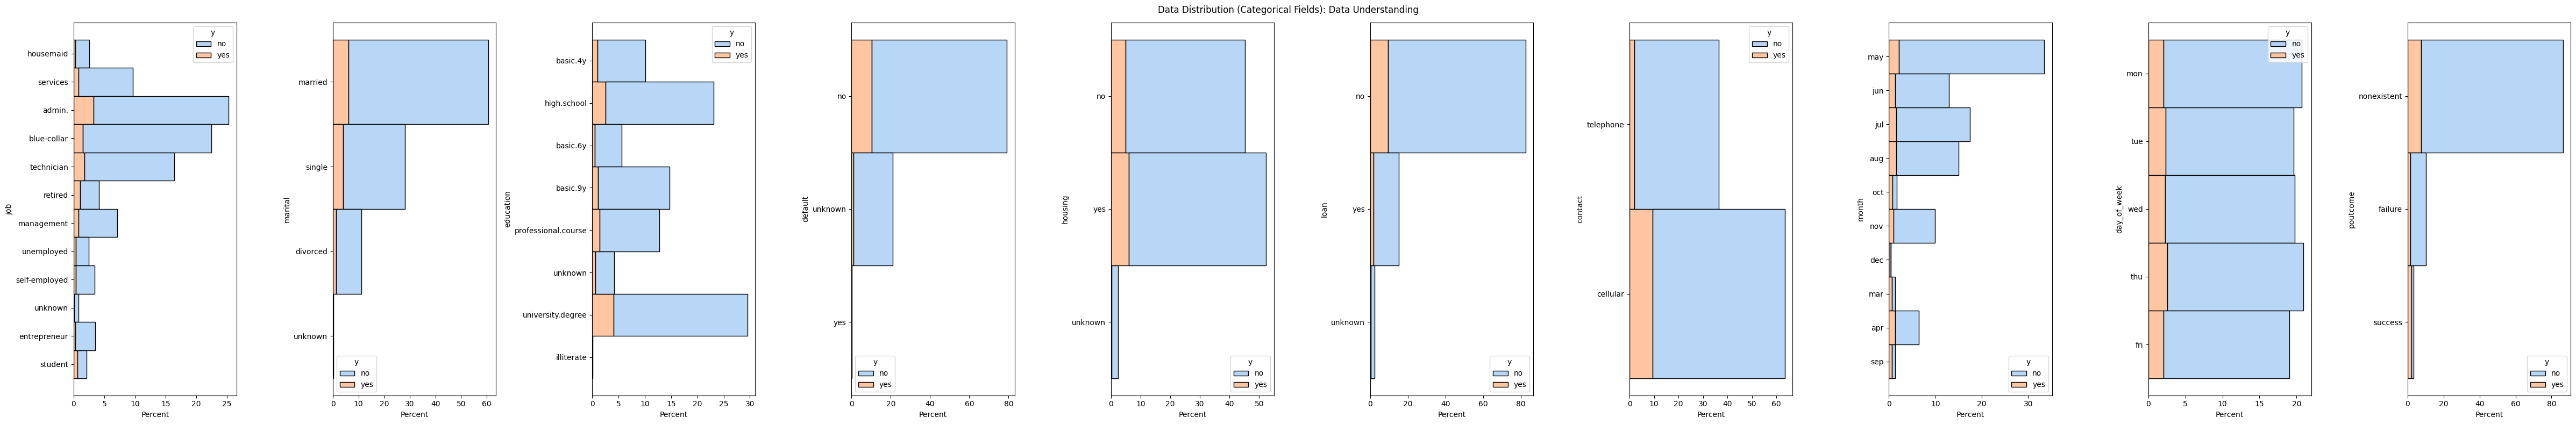

In [6]:
%time
cellStartTime = timeit.default_timer()

filePrefix = STEP03_PREFIX
rawDf = df
dataReportDf = addMetadataStatistics('raw', rawDf)
display(dataReportDf)
writeDataFrameDetails(data=rawDf, targetField=TARGET_FIELD, fileNameSuffix=filePrefix, titleSuffix=': Data Understanding')

problem3Content = ''
problem3Content += '### Features\n'

problem3Content += "```\n"
problem3Content += "Input variables:\n"
problem3Content += "# bank client data:\n"
problem3Content += "1 - age (numeric)\n"
problem3Content += "2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')\n"
problem3Content += "3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)\n"
problem3Content += "4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')\n"
problem3Content += "5 - default: has credit in default? (categorical: 'no','yes','unknown')\n"
problem3Content += "6 - housing: has housing loan? (categorical: 'no','yes','unknown')\n"
problem3Content += "7 - loan: has personal loan? (categorical: 'no','yes','unknown')\n"
problem3Content += "# related with the last contact of the current campaign:\n"
problem3Content += "8 - contact: contact communication type (categorical: 'cellular','telephone')\n"
problem3Content += "9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')\n"
problem3Content += "10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')\n"
problem3Content += "11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.\n"
problem3Content += "# other attributes:\n"
problem3Content += "12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)\n"
problem3Content += "13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)\n"
problem3Content += "14 - previous: number of contacts performed before this campaign and for this client (numeric)\n"
problem3Content += "15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')\n"
problem3Content += "# social and economic context attributes\n"
problem3Content += "16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)\n"
problem3Content += "17 - cons.price.idx: consumer price index - monthly indicator (numeric)\n"
problem3Content += "18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)\n"
problem3Content += "19 - euribor3m: euribor 3 month rate - daily indicator (numeric)\n"
problem3Content += "20 - nr.employed: number of employees - quarterly indicator (numeric)\n"

problem3Content += "Output variable (desired target):\n"
problem3Content += "21 - y - has the client subscribed a term deposit? (binary: 'yes','no')\n\n"
problem3Content += "```\n"

problem3Content += '#### Analysis\n'
problem3Content += 'Data has no missing values so we will examine content as based on the infromation it seems like empty values have been substituted\n'
problem3Content += '#### Data Distributions\n'
img = addMarkdownImage('Categorical Data Distribution', filePrefix + 'categorical.data.distribution.png')
problem3Content += f'{img}\n\n'

img = addMarkdownImage('Numerical Data Distribution', filePrefix + 'numeric.data.distribution.png')
problem3Content += f'{img}\n\n'

problem3Content += '#### Decisions\n'
problem3Content += '| Column | Notes | Decision |\n'
problem3Content += '| ------ | ----- | -------- |\n'
problem3Content += '| pdays | Majority of values are 999 | Drop column |\n'
problem3Content += '| job, marital, education, housing, loan | Unknown values account for small percentage of dataset | Drop rows |\n'
problem3Content += '| poutcome  | non-existent values account for large percentage and doesn\'t add value  | Drop column |\n'
problem3Content += '| default  | most are no or unknown and doesn\'t add value | Drop column |\n'
problem3Content += '| duration  | Per the information we should drop this column as it is not known at the time the prediction needs to be made. We can use it for benchmarking | Keep column but drop before finalizing final model |\n'
#problem3Content += '| duration  | Per the notes this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model | Drop column |\n'
problem3Content += '| nr.employed  | This has no bearing on whether a customer will sign up as it doesn\'t represent information the customer would have for their decision | Drop column |\n'

RUNTIME_METRICS['Problem 3 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem3Content, RESULT_FILE_PREFIX + 'problem03.md')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [7]:
df.info()
problem4Content = ''
problem4Content += '## CRISP DM: Business Understanding\n'
problem4Content += '### Business Objective\n'
problem4Content += 'Our goal is to:\n'
problem4Content += '- First find a model that best predicts whether a user will sign up for a long term deposit after several contacts from a marketing campaign.\n'
problem4Content += '- Second use the model to explain what features contribute most significantly to the outcome of user signing up for a deposit.\n'
problem4Content += '- Lastly use this information to offer guidance to the bank on which customers to target based on features or approach so we can minimize resources, time and thus cost and maximize the desired result.\n'
writeString2File(problem4Content, RESULT_FILE_PREFIX + 'problem04.md')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 1.91 µs
Processing: dropDuplicates
Processing: drop
Processing: queryFilter
Original Numeric Features: ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
Original Categorical Features: ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'y']
<class 'pandas.core.frame.DataFrame'>
Index: 38234 entries, 0 to 41187
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38234 non-null  int64  
 1   duration                       38234 non-null  int64  
 2   campaign                       38234 non-null  int64  
 3   previous                       38234 non-null  int64  
 4   emp.var.rate                   38234 non-null  float64
 5   cons.price.idx                 38234 non-null  float64
 6   cons.conf.idx         

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 2400x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 3840x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

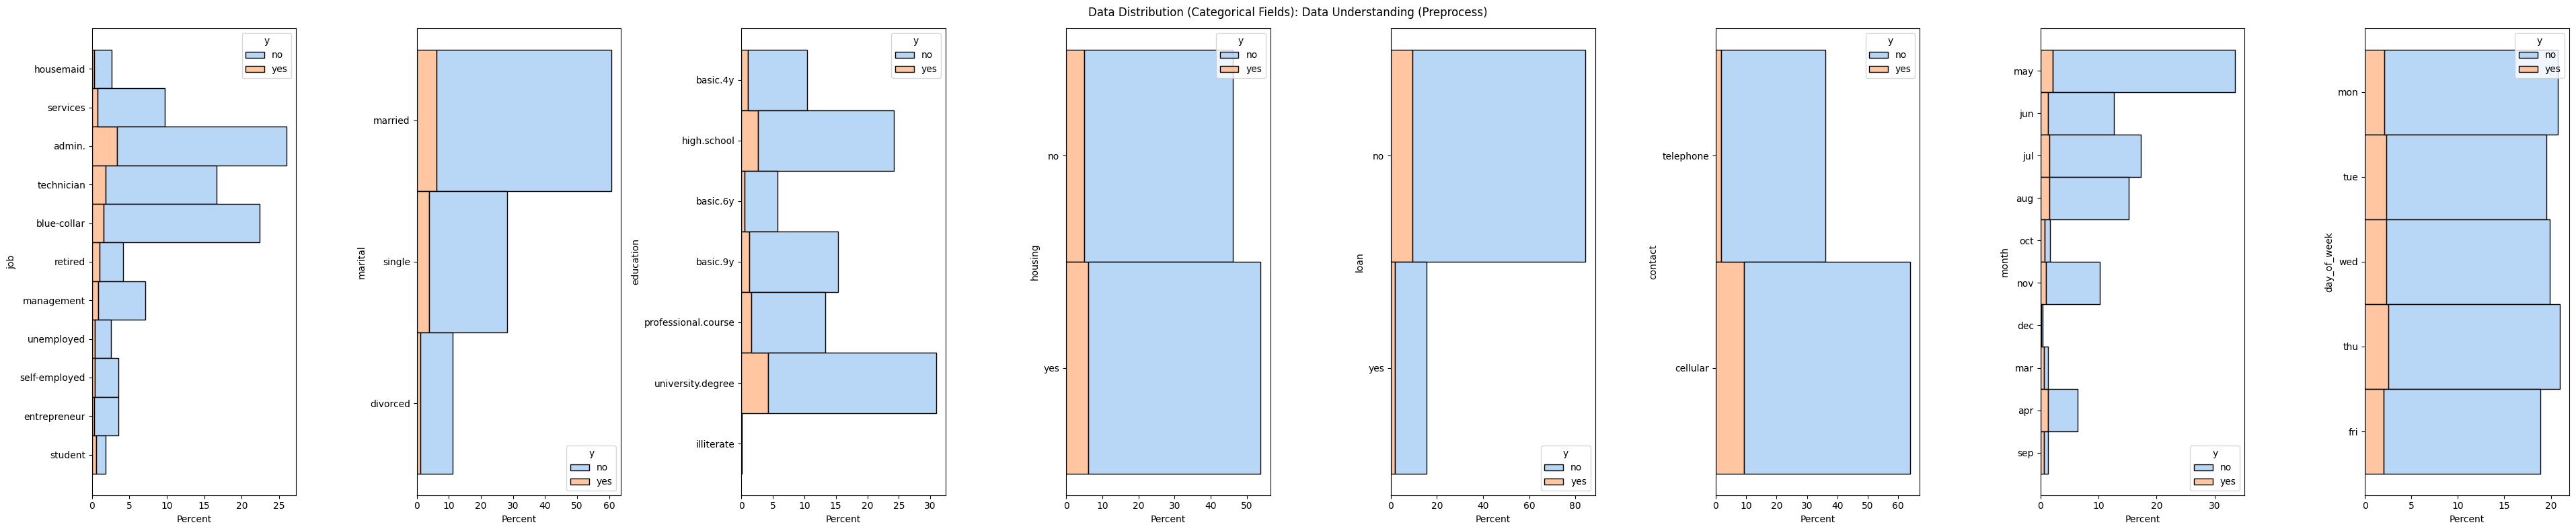

In [8]:
%time
cellStartTime = timeit.default_timer()

dataPreparationRequest = {
    'excludeColumnsFromReport': ['y'],
    'operations': [
        {
            'operation': 'dropDuplicates'
        },
         {
                'operation': 'drop',
                'config' : {
                    'poutcome': {},
                    'default': {},
                    'pdays': {},
                    'nr.employed': {}
                }
         },
        {
            'operation': 'queryFilter',
            'config': {
                'Drop rows with unknown': {
                    'query': 'job != "unknown" & marital != "unknown" & education != "unknown" & housing != "unknown" & loan != "unknown"'
                }
            }
        }
    ],
    'labels': {
        'row_count': 'Row Count',
        'na_value_count': 'Empty Value #',
        'na_value_pct': 'Empty Value %',
        'unq_value_count': 'Unique Value Counts',
        'column': 'Feature'
    }
}
filePrefix = STEP05_PREFIX
preProcessedDf, dataReportDf = preProcessData(dataPreparationRequest, rawDf, dataReportDf)
displayStats(request=dataPreparationRequest, dataReportDf=dataReportDf, prefix=filePrefix)
writeDataFrameDetails(data=preProcessedDf, targetField=TARGET_FIELD, fileNameSuffix=filePrefix, titleSuffix=': Data Understanding (Preprocess)')

numericFeatures = list(preProcessedDf.select_dtypes(include=[np.number]).columns.values)
categoricalFeatures = list(preProcessedDf.select_dtypes(exclude=[np.number]).columns.values)
print('Original Numeric Features: '+ str(numericFeatures))
print('Original Categorical Features: '+ str(categoricalFeatures))

numericFeaturesUsed = numericFeatures.copy()
categoricalFeaturesUsed = categoricalFeatures.copy()
for rf in IGNORE_FEATURES:
    if rf in numericFeaturesUsed:
        numericFeaturesUsed.remove(rf)
    if rf in categoricalFeaturesUsed:
        categoricalFeaturesUsed.remove(rf)

# Do transform for categorical now because baking into pipeline means sometings columns in training set aren't in test and vice versa
# Set target field to age since in this case we want to convert the y target field to numeric
experimentDf = encodeAndAddCategoricalColumns(preProcessedDf, 'age', categoricalFeaturesUsed)
finalNumericFeatures = list(experimentDf.select_dtypes(include=[np.number]).columns.values)
experimentDf = experimentDf[finalNumericFeatures]
experimentDf = experimentDf.rename(columns={"y_yes": "y"})
print(experimentDf.info())

problem5Content = ''
problem5Content += '## CRISP DM: Data Preparations\n'
problem5Content += '### Feature Engineering Decisions\n'
problem5Content += 'We are asked to focus on just the "bank client data" features. In order to simplify later steps though we will also make some decisions around the "other attributes" and "social and economic context attributes" features to be efficent in our data preparation.\n'
problem5Content += '| Fields | Operation | Notes |\n'
problem5Content += '| ------ | ----- | -------- |\n'
operations = dataPreparationRequest['operations']
for node in operations:
    fields = []
    operation = ''
    notes = ''
    operationName = node['operation']
    if operationName == 'dropDuplicates':
        operation = 'Drop duplicates'
        problem5Content += f'| {fields} | {operation} | {notes} |\n'
    elif operationName == 'drop':
        operation = 'Drop columns'
        configNode = node['config']
        fields = list(configNode.keys())
        problem5Content += f'| {fields} | {operation} | {notes} |\n'
    elif operationName == 'queryFilter':
        operation = 'Filter rows'
        configNode = node['config']
        for f in configNode:
            queryNode = configNode[f]
            desc = f
            query = queryNode['query']
            notes = f'Query: {query}'
            problem5Content += f'| {fields} | {operation} | {notes} |\n'



fields = ['ALL CATEGORICAL']
operation = 'One hot encode'
notes = 'All categorical columns with < 255 unique values'
problem5Content += f'| {fields} | {operation} | {notes} |\n'

fields = ['ALL CATEGORICAL']
operation = 'Drop'
notes = ''
problem5Content += f'| {fields} | {operation} | {notes} |\n'

fields = ['y_yes']
operation = 'rename'
notes = 'rename to y'
problem5Content +=f'| {fields} | {operation} | {notes} |\n'


problem5Content += '### Data Distributions\n'
img = addMarkdownImage('Categorical Data Distribution', filePrefix + 'categorical.data.distribution.png')
problem5Content += f'{img}\n\n'

img = addMarkdownImage('Numerical Data Distribution', filePrefix + 'numeric.data.distribution.png')
problem5Content += f'{img}\n\n'

problem5Content += '### Data Composition Change Tracking\n'
img = addMarkdownImage('Row Counts', filePrefix + 'row_count.png')
img = addMarkdownImage('Unique Value Counts', filePrefix + 'unique_values.png')
problem5Content += f'{img}\n\n'

RUNTIME_METRICS['Problem 5 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem5Content, RESULT_FILE_PREFIX + 'problem05.md')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
problem6Content = ''
problem6Content += '### Train/Test Split\n'
problem6Content += 'We will use the traditional split of 70% train / 30% split\n'
writeString2File(problem6Content, RESULT_FILE_PREFIX + 'problem06.md')

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DummyClassifier(random_state=42))])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

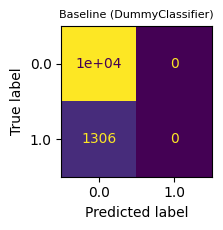

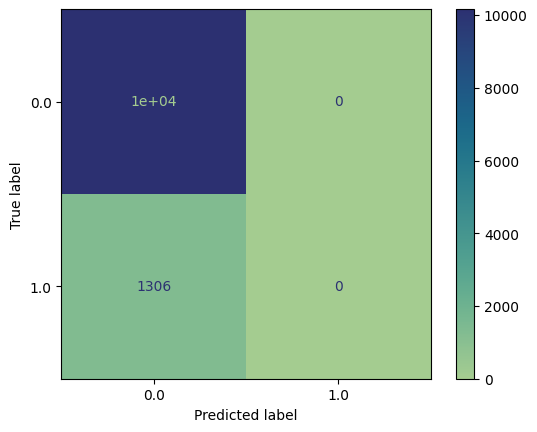

In [10]:
# Setting this so information from previous sections does not bleed in
name = None
filePrefix = None
reportDf = None
importantFeatureDf = None
classBalanceDf =  None

# Begin
name = 'Baseline'
filePrefix=STEP07_PREFIX
reportDf, importantFeatureDf, classBalanceDf = runAnalysis(name=name, 
                                                           filePrefix=filePrefix, 
                                                           data=experimentDf, 
                                                           targetField=TARGET_FIELD, 
                                                           models2Try=BASELINE_MODEL_2_TRY,
                                                           directModel=True,
                                                           scoringTypes=DEFAULT_GRID_SEARCH_SCORING_TYPES)
printResults(name=name, filePrefix=filePrefix, reportDf=reportDf, classBalanceDf=classBalanceDf, 
             showTestScore=False, showTrainScore=False, showAvgFitTime=False, showClassMakeup=False)
dataFrame2Html(importantFeatureDf,  filePrefix + 'important_features')
writeDataFrame2Excel(reportDf, filePrefix)
writeDataFrame2Excel(importantFeatureDf, filePrefix + 'features')

# Store baseline score for use later
baselineModelTestScore = reportDf.iloc[0]['test score'] * 100

problem7Content = ''
problem7Content += '## CRISP DM: Modeling\n'
problem7Content += '- We will use the accuracy of the test score to evaluate the models against each other and select best model during Grid Search.\n'
problem7Content += '- However if the bank had an opinon for example one of the ones below we would adjust the scoring type.\n'
problem7Content += '  - Recall: If we wanted to make sure we didn\'t miss any customers that may sign up we would optimize for recall.\n'
problem7Content += '  - Precision: If we wanted to make sure we only spend time contacting customers that are likely sign up we would optimize for precision.\n'
problem7Content += '### Baseline Model\n'
problem7Content += printModelAnalysis(reportDf=reportDf, filePrefix=filePrefix, baselineScore=baselineModelTestScore, isBaseline=True)
writeString2File(problem7Content, RESULT_FILE_PREFIX + 'problem07.md')

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

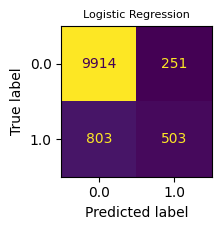

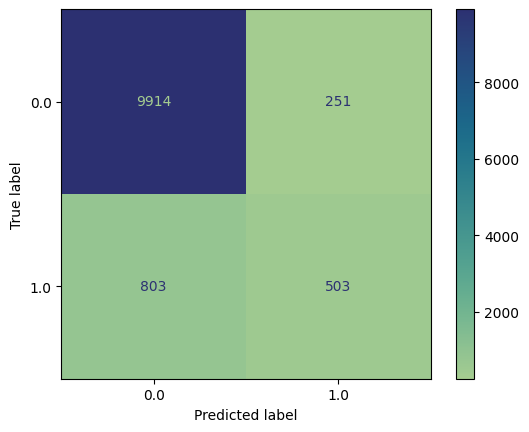

In [11]:
%time
cellStartTime = timeit.default_timer()

# Setting this so information from previous sections does not bleed in
name = None
filePrefix = None
reportDf = None
importantFeatureDf = None
classBalanceDf =  None

# Begin
name = 'Simple Model - Logistic Regression'
filePrefix=STEP08_PREFIX
reportDf, importantFeatureDf, classBalanceDf = runAnalysis(name=name, 
                                                           filePrefix=filePrefix, 
                                                           data=experimentDf, 
                                                           targetField=TARGET_FIELD, 
                                                           models2Try=SIMPLE_MODEL_2_TRY,
                                                           directModel=True,
                                                           scoringTypes=DEFAULT_GRID_SEARCH_SCORING_TYPES)
printResults(name=name, filePrefix=filePrefix, reportDf=reportDf, classBalanceDf=classBalanceDf, 
             showTestScore=False, showTrainScore=False, showAvgFitTime=False, showClassMakeup=False)
dataFrame2Html(importantFeatureDf,  filePrefix + 'important_features')
writeDataFrame2Excel(reportDf, filePrefix)
writeDataFrame2Excel(importantFeatureDf, filePrefix + 'features')

problem8Content = ''
problem8Content += '### A Simple Model (Logistic Regression)\n'
problem8Content += 'We are training a Logistic Regression model with default values\n'

problem9Content = ''
problem9Content += printModelAnalysis(reportDf=reportDf, filePrefix=filePrefix, baselineScore=baselineModelTestScore)

RUNTIME_METRICS['Problem 9 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem9Content, RESULT_FILE_PREFIX + 'problem09.md')

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

CPU times: user 2 µs, sys: 21 µs, total: 23 µs
Wall time: 4.77 µs


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=42))])

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(random_state=42))])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

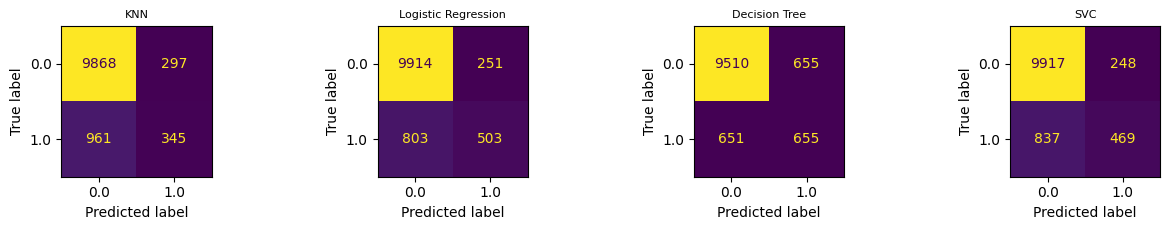

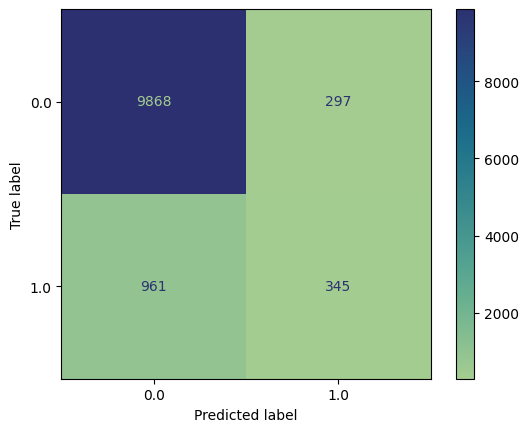

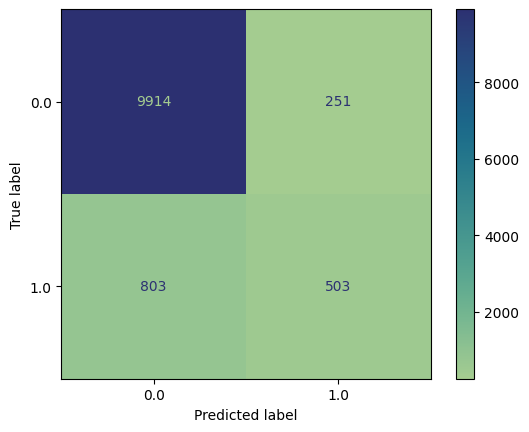

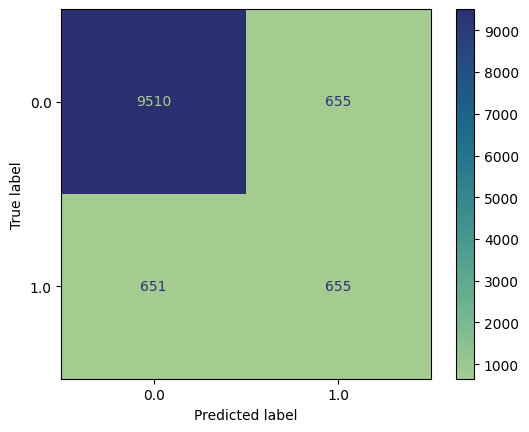

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

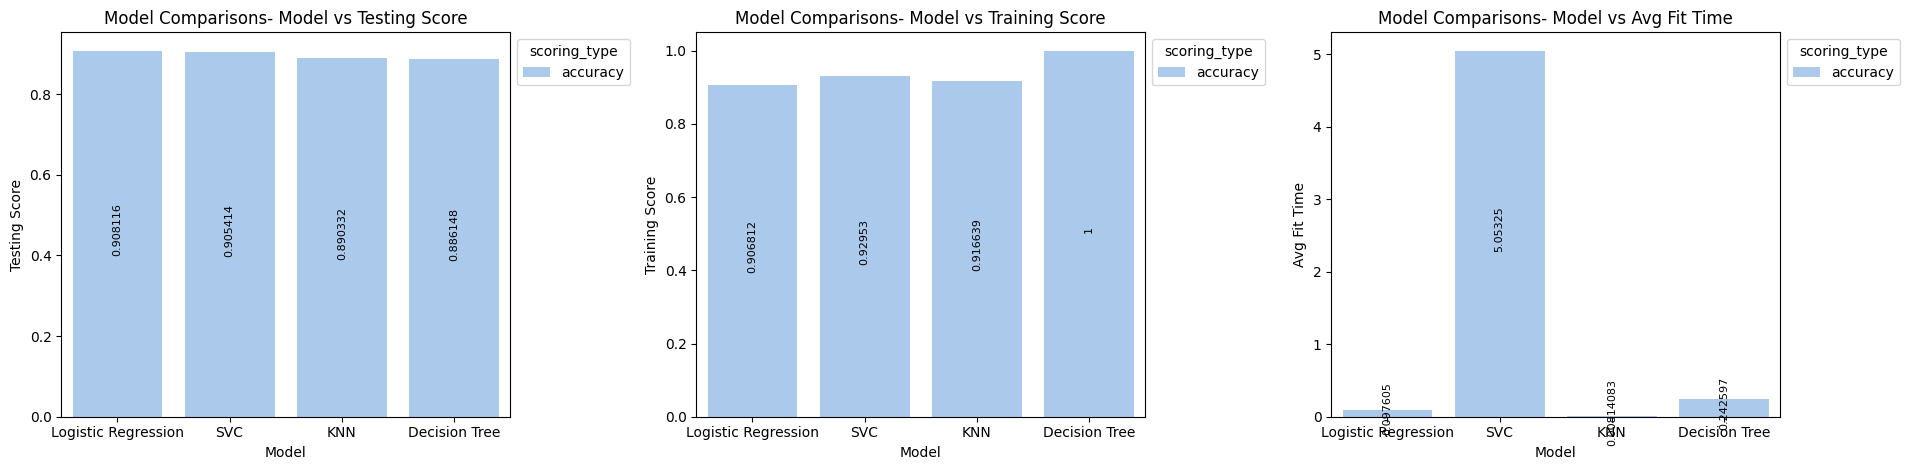

In [12]:
%time
cellStartTime = timeit.default_timer()

# Setting this so information from previous sections does not bleed in
name = None
filePrefix = None
reportDf = None
importantFeatureDf = None
classBalanceDf =  None

# Begin
name = 'Model Comparisons'
filePrefix=STEP10_PREFIX
reportDf, importantFeatureDf, classBalanceDf = runAnalysis(name=name, 
                                                           filePrefix=filePrefix, 
                                                           data=experimentDf, 
                                                           targetField=TARGET_FIELD, 
                                                           models2Try=DEFAULT_MODELS_2_TRY,
                                                           directModel=True,
                                                           scoringTypes=DEFAULT_GRID_SEARCH_SCORING_TYPES)
printResults(name=name, filePrefix=filePrefix, reportDf=reportDf, classBalanceDf=classBalanceDf, 
             showClassMakeup=False)
dataFrame2Html(importantFeatureDf,  filePrefix + 'important_features')
writeDataFrame2Excel(reportDf, filePrefix)
writeDataFrame2Excel(importantFeatureDf, filePrefix + 'features')

problem10Content = ''
problem10Content += '### Multiple Default Model Comparisons\n'
problem10Content += 'Comparing mutlipel models using default hyperparameters/settings we find.\n'
problem10Content += printModelAnalysis(reportDf=reportDf, filePrefix=filePrefix, baselineScore=baselineModelTestScore, printPerformanceGraphs=True)

RUNTIME_METRICS['Problem 10 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem10Content, RESULT_FILE_PREFIX + 'problem10.md')

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'y']


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(1, 75),
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['l2', 'elasticnet']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 11)},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(1, 75),
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['l2', 'elasticnet']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 11)},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(1, 75),
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['l2', 'elasticnet']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 11)},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(1, 75),
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['l2', 'elasticnet']},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 11)},
             scoring='accuracy')

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

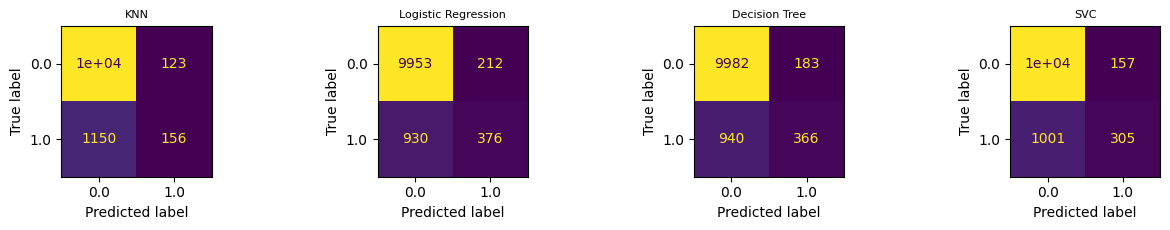

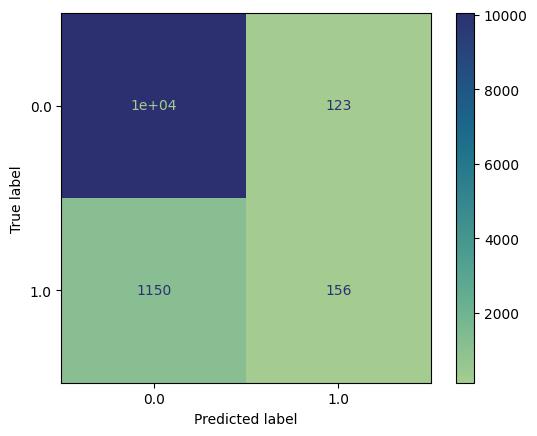

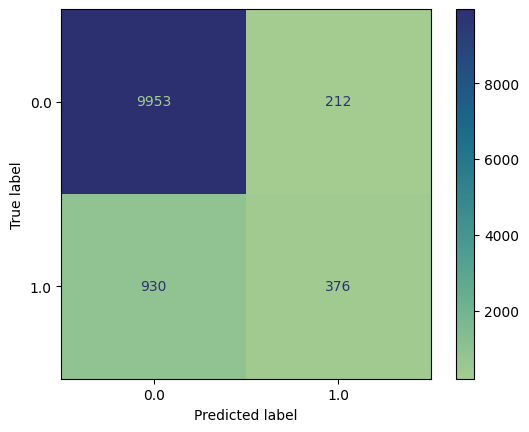

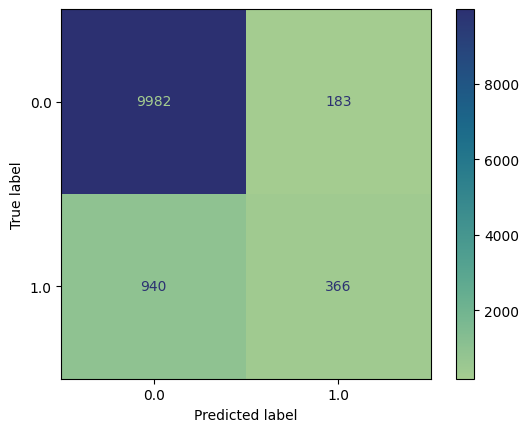

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 2560x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

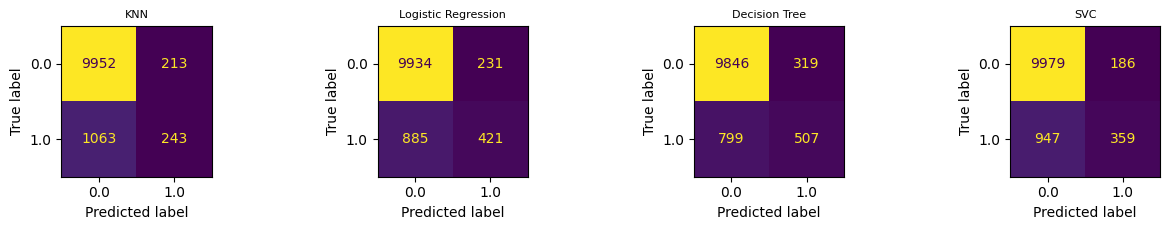

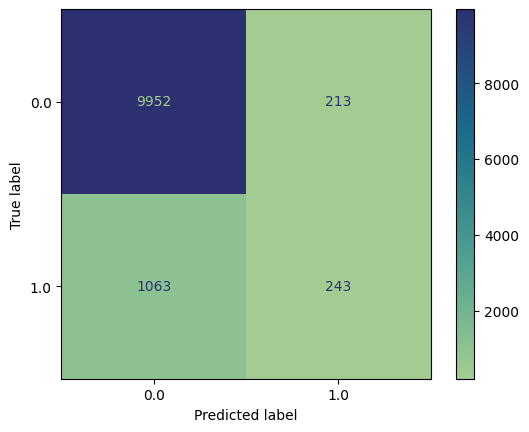

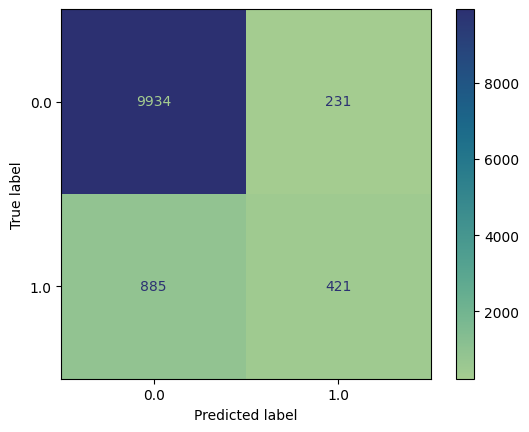

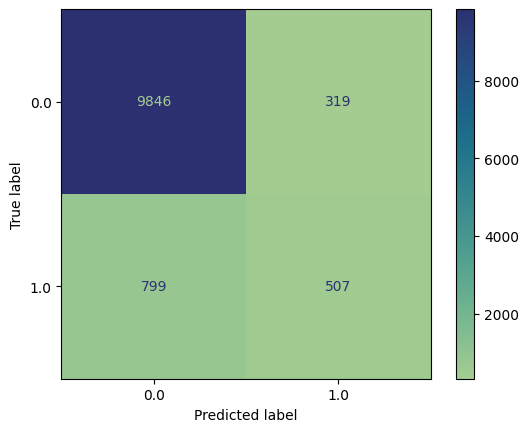

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 2560x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

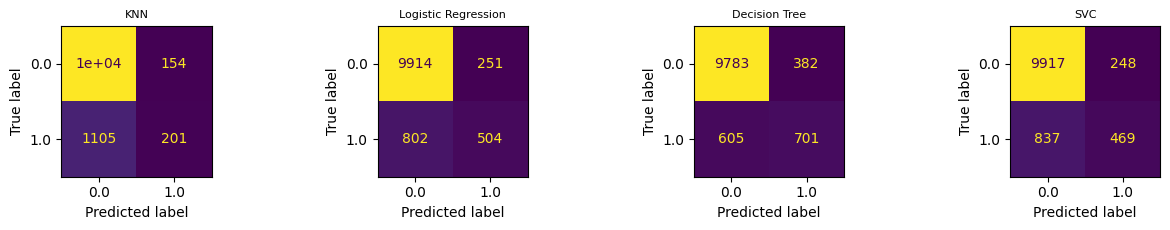

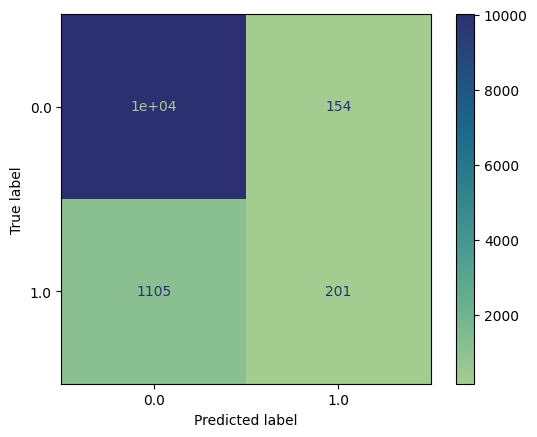

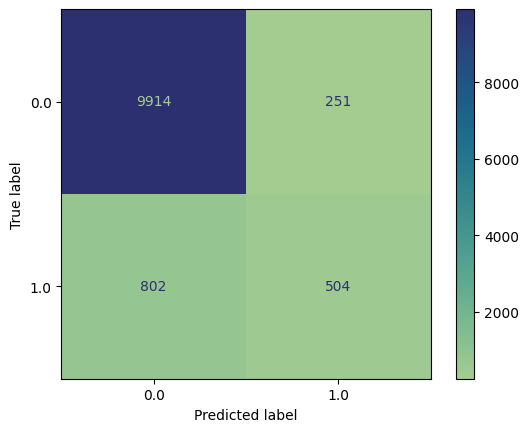

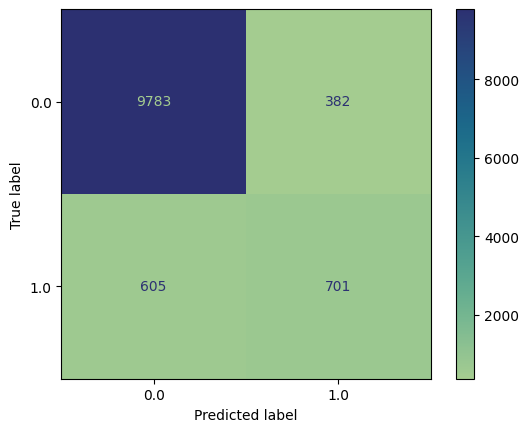

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 2560x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

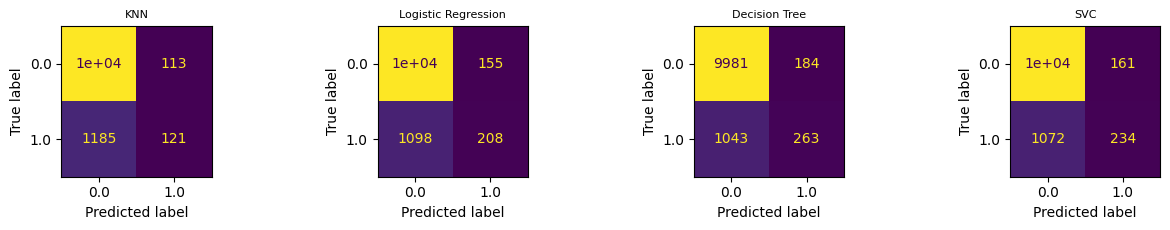

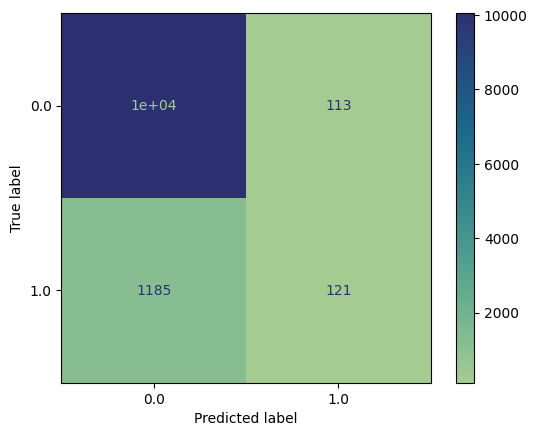

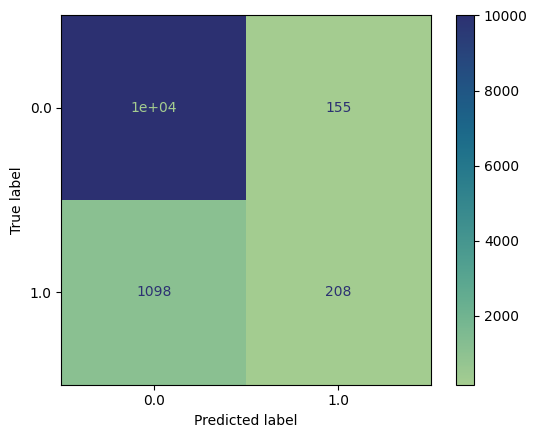

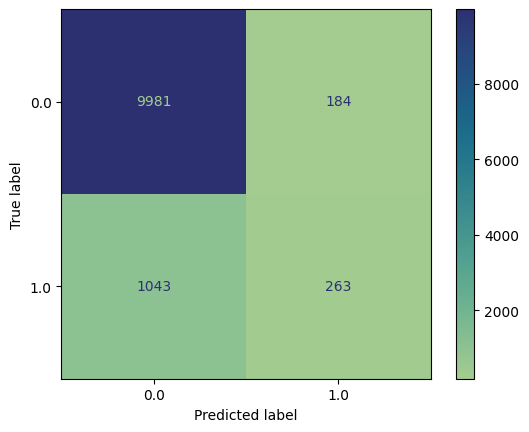

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

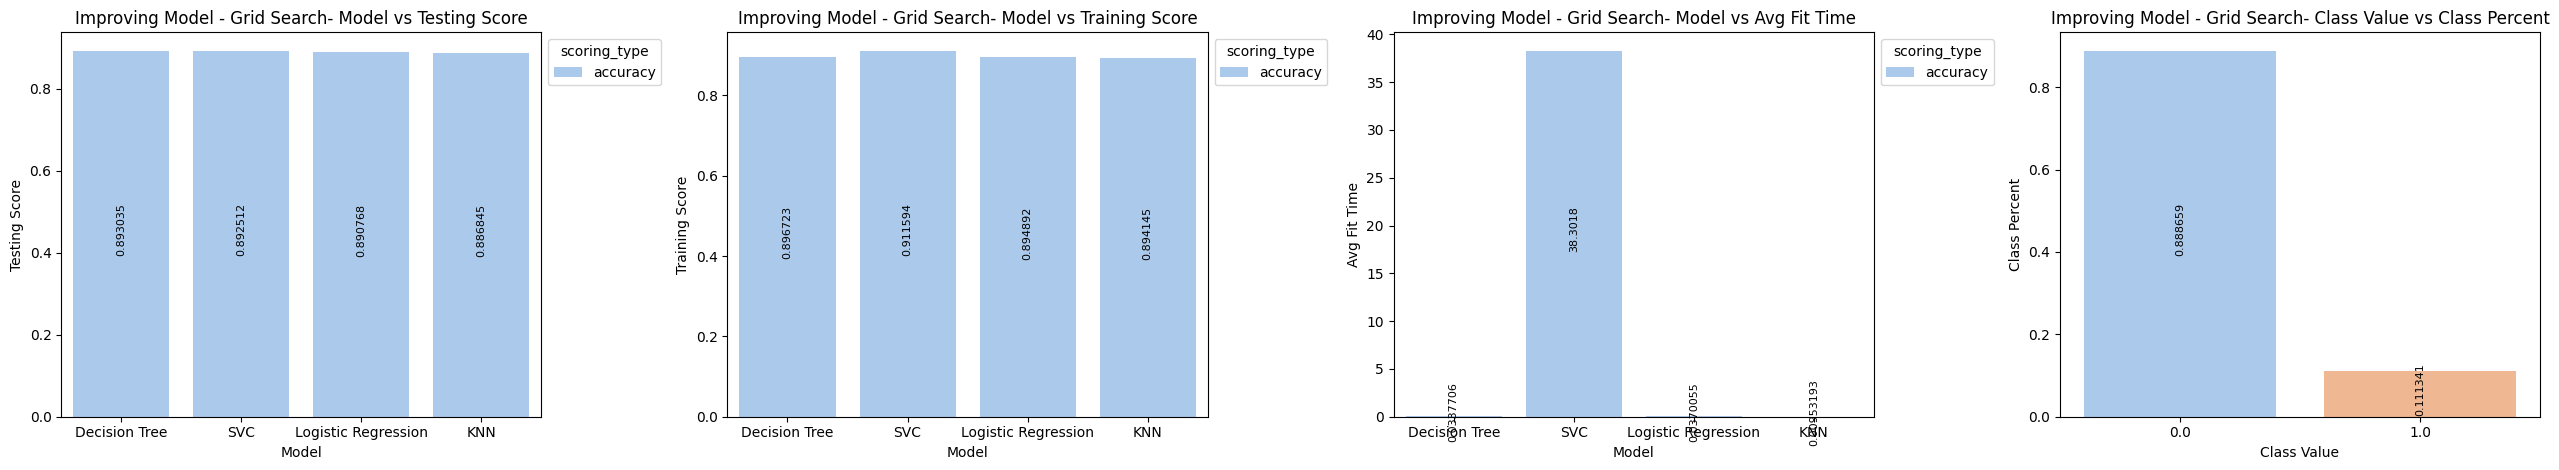

In [13]:
%time
cellStartTime = timeit.default_timer()

# Setting this so information from previous sections does not bleed in
name = None
filePrefix = None
reportDf = None
importantFeatureDf = None
classBalanceDf =  None

# Begin
def runExperiment(name, filePrefix, data):
    reportDf, importantFeatureDf, classBalanceDf = runAnalysis(name=name, 
                                                           filePrefix=filePrefix, 
                                                           data=data, 
                                                           targetField=TARGET_FIELD, 
                                                           models2Try=GRID_SEARCH_MODELS_2_TRY,
                                                           scoringTypes=DEFAULT_GRID_SEARCH_SCORING_TYPES)
    printResults(name=name, filePrefix=filePrefix, reportDf=reportDf, classBalanceDf=classBalanceDf)
    dataFrame2Html(importantFeatureDf,  filePrefix + 'important_features',)
    writeDataFrame2Excel(reportDf, filePrefix)
    writeDataFrame2Excel(importantFeatureDf, filePrefix + 'features')

    content = ''
    content += printModelAnalysis(reportDf=reportDf, filePrefix=filePrefix, baselineScore=baselineModelTestScore, printPerformanceGraphs=True)

    return content, reportDf, importantFeatureDf, classBalanceDf


name = 'Improving Model - Grid Search'
problem11Content = ''
currentDataFrameColumns = list(experimentDf.columns.values)
print(currentDataFrameColumns)
for ek in EXPERIMENTS:
    experiment = EXPERIMENTS[ek]
    filePrefix = STEP11_PREFIX + ek + '.'
    experiment['filePrefix'] = filePrefix
    experimentName = experiment['name']
    experimentDescription = experiment['description']
    experimentFeatures = experiment['features']
    finalFeatures = []
    for dfk in currentDataFrameColumns:
        for fk in experimentFeatures:
            if dfk.startswith(fk):
                finalFeatures.append(dfk)
    experiment['encodedFeatures'] = finalFeatures
    data = experimentDf[finalFeatures]
    problem11Content += f'### Grid Search - {experimentName}\n'
    problem11Content += f'{experimentDescription}\n'
    content, reportDf, importantFeatureDf, classBalanceDf = runExperiment(name=name, filePrefix=filePrefix, data=data)
    problem11Content += content
    experiment['reportDf'] = reportDf
    experiment['importantFeatureDf'] = importantFeatureDf
    experiment['classBalanceDf'] = classBalanceDf

RUNTIME_METRICS['Problem 11 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem11Content, RESULT_FILE_PREFIX + 'problem11.md')

## Problem 12: Evaluation

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


<Figure size 640x480 with 0 Axes>

<Figure size 7200x3200 with 0 Axes>

<Figure size 9600x12800 with 0 Axes>

<Figure size 6000x1600 with 0 Axes>

<Figure size 14400x1600 with 0 Axes>

<Figure size 1800x1600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 2880x800 with 0 Axes>

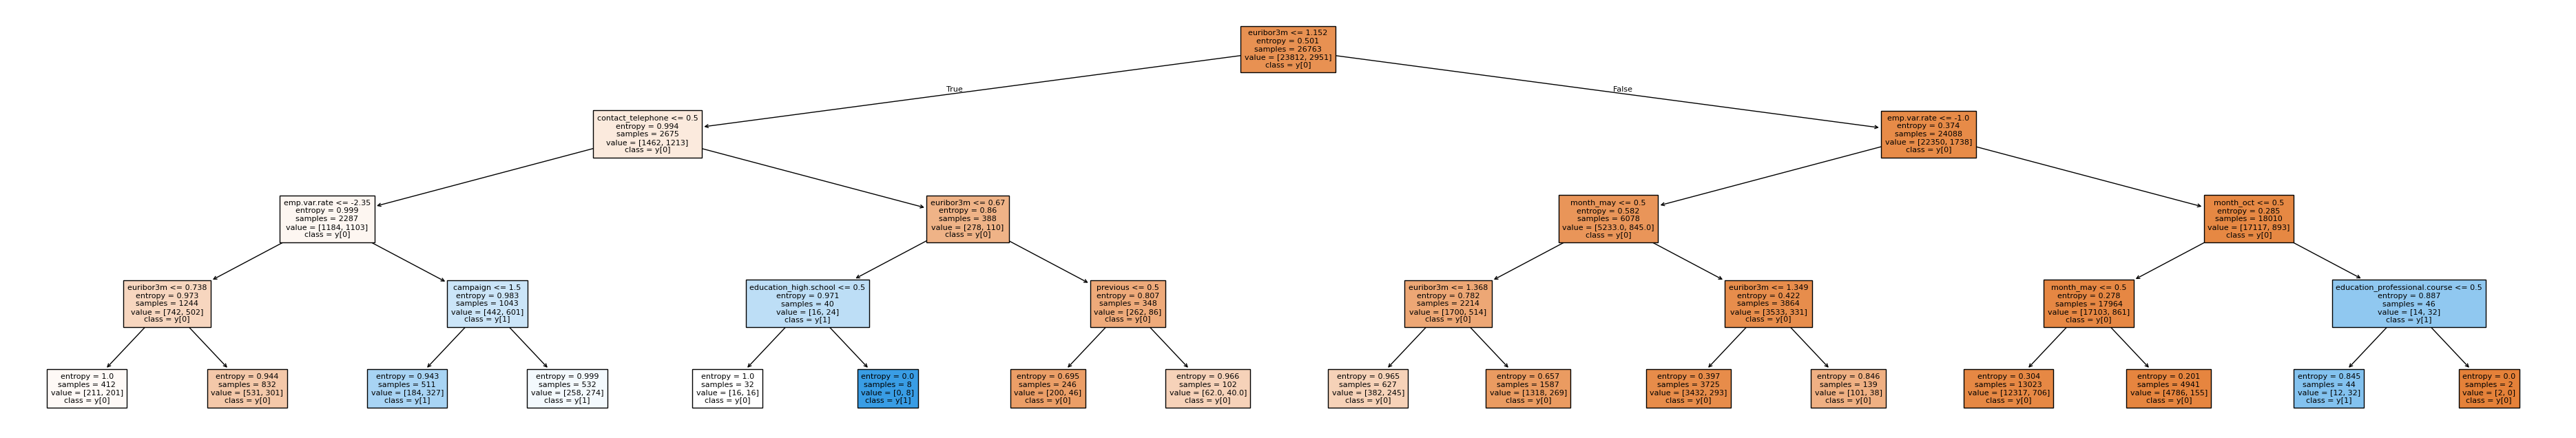

In [14]:
%time
cellStartTime = timeit.default_timer()

# Setting this so information from previous sections does not bleed in
name = None
filePrefix = None
reportDf = None
importantFeatureDf = None
classBalanceDf =  None

# Begin
def runEvaluation(filePrefix, key, experiment):
    # Gather data and previous results
    targetField = TARGET_FIELD
    experimentName = experiment['name']
    experimentFilePrefix = experiment['filePrefix']
    experimentDescription = experiment['description']
    experimentFeatures = experiment['encodedFeatures']
    experimentRawFeatures = experiment['features']
    printDistributionGraphs = False
    if 'printDistributionGraphs' in experiment:
        printDistributionGraphs = experiment['printDistributionGraphs']

    printDecisionTree = True
    if 'printDecisionTree' in experiment:
        printDecisionTree = experiment['printDecisionTree']
    data = experimentDf[experimentFeatures]
    reportDf = experiment['reportDf']
    importantFeatureDf = experiment['importantFeatureDf']

    content = ''
    content += f'### {experimentName}\n'

    encodedImportantFeatures = list(importantFeatureDf['feature'].values)
    # Print important feeatures
    if importantFeatureDf.shape[0] > 0:
        features = encodedImportantFeatures
        # Determine important fields
        finalImportantFieldsContent = []
        for f in features:
            column = f.split('_')[0]
            if column not in finalImportantFieldsContent:
                finalImportantFieldsContent.append(column)
        content += '#### Feature Importance\n'
        content += f'\nImportant features using voting approach:\n\n{finalImportantFieldsContent}\n\n'
        content += f'The specific values of these important features are:\n'
        
        content +=  pd.read_html(RESULT_FILE_PREFIX + STEP11_PREFIX + f'{key}.important_features.dataFrame.html')[0].to_html(index=False, index_names=False, notebook=True)
        content += '\n\n'
        

    # Show distribution graphs
    if printDistributionGraphs:
        # Special treatment for visualization
        ageField = 'age'

        # Some of these columns won't be in the pre-processed set so filter out
        preProcessedColumns = preProcessedDf.columns.values
        analyzeColumns = []
        for f in experimentRawFeatures:
            if f in preProcessedColumns:
                analyzeColumns.append(f)
                
        # Get complete list of columns to analyze + target field
        if targetField not in analyzeColumns:
            analyzeColumns.append(targetField)
        if ageField not in analyzeColumns:
            analyzeColumns.append(ageField)
        
        analysisDf = preProcessedDf[analyzeColumns]
    
        # Numeric fields we want to render differently
        numCols = list(analysisDf.select_dtypes(include=[np.number]).columns.values)
        if ageField in numCols:
            numCols.remove(ageField)
        if targetField not in numCols:
            numCols.append(targetField)
    
        # Categorical we want to see possibility of success
        catCols = list(analysisDf.select_dtypes(exclude=[np.number]).columns.values)
        if ageField in catCols:
            catCols.remove(ageField)
        if targetField not in catCols:
            catCols.append(targetField)

    
        # Finaly generate graphs
        generatePercentCompositionBarReport4Columns({}, df2Use=analysisDf, targetField=targetField, columns=catCols, 
                                                    fileSuffix=filePrefix + 'important.categorical.data.distribution', 
                                                    baseWidth=1800, baseHeight=1600, 
                                                    highlightColumns=finalImportantFieldsContent)
        # Age we want to render by itself for visibility
        generatePercentCompositionBarReport4Columns({}, df2Use=analysisDf, targetField=targetField, columns=[ageField], 
                                                    fileSuffix=filePrefix + 'important.age.data.distribution', 
                                                    baseWidth=1800, baseHeight=1600, 
                                                    highlightColumns=finalImportantFieldsContent)
    
    
    
        writeDataFrameDetails(data=analysisDf[numCols], targetField=targetField, 
                              fileNameSuffix=filePrefix + 'important', titleSuffix=': Final Report',
                              highlightColumns=finalImportantFieldsContent)
        content += '#### Analysis\n'
        content += '#### Data Distributions\n'
        content += '**NOTE:** Important features highlighted using different palette\n'
        img = addMarkdownImage('Important Categorical Data Distribution', filePrefix + 'important.categorical.data.distribution.png')
        content += f'{img}\n'
        img = addMarkdownImage('Important Age Data Distribution', filePrefix + 'important.age.data.distribution.png')
        content += f'{img}\n\n'
        img = addMarkdownImage('Numerical Data Distribution', filePrefix + 'important.numeric.data.distribution.png')
        content += f'{img}\n\n'
    
    # Show decision tree
    if printDecisionTree:
        decisionTreeBestParams = reportDf.loc[reportDf['model'] == 'Decision Tree'].iloc[0]['best_params']
        params = json.loads(decisionTreeBestParams)
        maxDepth = params['max_depth']
    
        # Train the model
        targetField = TARGET_FIELD
        featureFields = list(data.columns.values)
        featureFields.remove(targetField);
        X = experimentDf[featureFields]
        y = experimentDf[[targetField]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        model = DecisionTreeClassifier(random_state=42, criterion=params['criterion'], max_depth=maxDepth)
        model.fit(X_train, y_train)
    
        #display(model)
        # https://mljar.com/blog/visualize-decision-tree/
        
        width = 12 * maxDepth
        height = 0.5 * (2 ** maxDepth)    
        plt.clf()
        fig, ax = plt.subplots(figsize = (width, height))
        featureNames = list(X_train.columns)
        tree_plot = plot_tree(model, 
                              ax = ax,
                              feature_names=featureNames, 
                              class_names=True,
                              filled=True,  
                              fontsize=8);
        
        fileSuffix = filePrefix + '.decision_tree_final.png'
        plt.savefig(IMAGE_PREFIX + fileSuffix)
        
        
        img = addMarkdownImage(name='Decision Tree', path=fileSuffix)
        content += '#### Decision Tree\n'
        content += 'The descision tree is more easily interpretable/explainable to help with the understanding how the model works and can help the bank make decisions about optimizing the campaign.\n'
        content += f'{img}\n'

    return content

filePrefix = STEP12_PREFIX
problem12Content = ''
problem12Content += '## CRISP DM: Evaluation\n'
problem12Content += 'Using a "voting" approach where each time a feature is deemed important by a model it increments the vote. Coefficents are including to evaluate direction and magnitude as well.\n'
for ek in EXPERIMENTS:
    experiment = EXPERIMENTS[ek]
    problem12Content += runEvaluation(filePrefix, ek, experiment)

RUNTIME_METRICS['Problem 12 Execution Time'] = timeit.default_timer() - cellStartTime
writeString2File(problem12Content, RESULT_FILE_PREFIX + 'problem12.md')

## Final Reporting

In [15]:
noteBookContent = '## Research Code\n'
noteBookContent += '**Code:** [Data Analysis Workbook](./prompt_III.out.ipynb)\n\n'
noteBookContent += '**NOTE:** *The processing of the juypter notebook take a long time and often disconnects from the session. In order to run it without monitoring it all the time use the wokraround below from command line.*\n'
noteBookContent += '```\n'
noteBookContent += 'jupyter nbconvert --to notebook --execute {input_notebook} --output={output_notebook} --ExecutePreprocessor.timeout=-1\n'
noteBookContent += '```\n'
noteBookContent += '<sub>Source: [screen-and-jupyter-a-way-to-run-long-notebooks-headles](https://www.maksimeren.com/post/screen-and-jupyter-a-way-to-run-long-notebooks-headless/)</sub>\n\n'
noteBookContent += 'Jump to the good stuff: [Summary, Observations and Guidance](#next-steps-summary-observations-and-guidance)\n'

readMeContent = ''
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem01.md')
readMeContent += noteBookContent
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem02.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem03.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem04.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem05.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem06.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem07.md')
#readMeContent += readFile( RESULT_FILE_PREFIX + 'problem08.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem09.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem10.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem11.md')
readMeContent += readFile( RESULT_FILE_PREFIX + 'problem12.md')




reportingContent = ''
reportingContent += '## Next Steps: Summary, Observations and Guidance\n'

featureReporting = {
    'month': {
        'observation': 'Certain months show better success than others e.g. March and months towards end of year.',
        'guidance': 'Maybe ramp down the calls to save on cost during the down months or increase calls during peak months.'
    },
    'age': {
        'observation': 'Ages above 60 and below have better success however have smaller numbers. There is a bracket between 30-35 with more success.',
        'guidance': 'Target customers in the brackets 30-35 and above 60.'
    },
    'job': {
        'observation': 'Middle class, students and retired folks more success.',
        'guidance': 'Target customers in the middle class jobs (particularly admin and technicians), retired people and students.'
    },
    'duration': {
        'observation': 'Durations of around 300 seconds appear to be more successful. Though this may just be a function of customers who were going to accept and having longer discussions.',
        'guidance': 'Plan on your agents spending at least 300 seconds to talk to customers. This is more of a staffing suggestion based on how many callouts.'
    },
    'campaign': {
        'observation': 'Seems like we have some success reaching out between 1-4 times.',
        'guidance': 'Don\'t bother calling customers more than 4 times.'
    },
    'cons.conf.idx': {
        'observation': 'These the bank has no control over this but it affects success.',
        'guidance': 'Adjust agent resources up/down based on this indicator.'
    },
    'cons.price.idx': {
        'observation': 'These the bank has no control over this but it affects success.',
        'guidance': 'Adjust agent resources up/down based on this indicator.'
    },
    'emp.var.rate': {
        'observation': 'These the bank has no control over this but it affects success.',
        'guidance': 'Adjust agent resources up/down based on this indicator.'
    },
    'euribor3m': {
        'observation': 'These the bank has no control over this but it affects success.',
        'guidance': 'Adjust agent resources up/down based on this indicator.'
    }
}

TICK = '&#10003;'
CROSS = '&#10007;'

# Model Summary
baseLineReportDf = pd.read_excel(RESULT_FILE_PREFIX + STEP07_PREFIX + f'dataFrame.xlsx')
baseLineScore = baseLineReportDf.iloc[0]['test score'] * 100
modelContent = '#### Model Observations and Guidance\n'
modelContent += f'- Our Baseline score: {baseLineScore:.5f}%\n'
modelContent += f'- Model Analysis:\n'
modelContent += '    - Observation: SVC always performs significantly slower that the other models.\n'
modelContent += '    - Guidance: For very large sets where compute resources are an issue during training we may stay away from SVM model.\n\n'

modelContent += '#### Experiment - Best Model and Hyperparameters\n'
modelContent += '<table>\n'
modelContent +='<tr><th>Experiment</th><th>Best Model</th><th>Best Parameters</th><th>Accuracy Test Score</th><th>Better Than Baseline</th><th>Important Features</th></tr>\n'

# Feature Summary
featureContent = '#### Experiment - Best Model Identified Important Features\n'
featureContent += '<table>\n'
featureContent +='<tr><th>Experiment</th><th>Feature</th><th>Value</th><th>Direction</th><th>Magnitude</th></tr>\n'


for ek in EXPERIMENTS:
    experiment = EXPERIMENTS[ek]
    experimentName = experiment['name']
    reportDf = pd.read_excel(RESULT_FILE_PREFIX + STEP11_PREFIX + f'{ek}.dataFrame.xlsx')
    importantFeatureDf = pd.read_excel(RESULT_FILE_PREFIX + STEP11_PREFIX + f'{ek}.features.dataFrame.xlsx')
    finalModelDecisionDf = reportDf.sort_values('test score', ascending=False)
    bestModel = finalModelDecisionDf.iloc[0]['model']
    bestParams = finalModelDecisionDf.iloc[0]['best_params']
    bestScore = finalModelDecisionDf.iloc[0]['test score'] * 100

    featuresEncoded = list(importantFeatureDf['feature'].values)
    # Determine important fields
    importanceIndicator = {}
    better = TICK if bestScore > baseLineScore else CROSS
    modelContent += f'<tr><td>{experimentName}</td><td>{bestModel}</th><td>{bestParams}</td><td>{bestScore:.5}%</td><td>{better}</td><td>{featuresEncoded}</td></tr>\n'

    experimentSpan = importantFeatureDf.shape[0]
    for index, row in importantFeatureDf.iterrows():
        feature = row['feature']
        coeff = row['sum_coefficients']
        parts = feature.split('_')
        column = parts[0]
        if(len(parts) > 1):
            featureValue = feature[len(column) + 1:]
            if column not in importanceIndicator:
                importanceIndicator[column] = {}
            columnNode = importanceIndicator[column]
            if featureValue not in columnNode:
                columnNode[featureValue] = {}
            featureNode = columnNode[featureValue]
            featureNode['coeff'] = coeff
        else:
            featureValue = '{numeric}'
            if column not in importanceIndicator:
                importanceIndicator[column] = {}
            columnNode = importanceIndicator[column]
            if featureValue not in columnNode:
                columnNode[featureValue] = {}
            featureNode = columnNode[featureValue]
            featureNode['coeff'] = coeff

    experimentRow = 0
    for ck in importanceIndicator:
        columnNode = importanceIndicator[ck]
        columnSpan = len(columnNode)
        columnRow = 0
        for fk in columnNode:
            featureNode = columnNode[fk]
            coeff = featureNode['coeff']
            if coeff > 0:
                indicator = '&#8679;'
            elif coeff < 0:
                indicator = '&#8681;'
            else:
                indicator = '&#8660;'
            if experimentRow == 0:
                featureContent += f'<tr><td rowspan="{experimentSpan}">{experimentName}</td><td rowspan="{columnSpan}">{ck}</td><td>{fk}</td><td>{indicator}</td><td>{coeff}</td></tr>\n'
            elif columnRow == 0:
                featureContent += f'<tr><td rowspan="{columnSpan}">{ck}</td><td>{fk}</td><td>{indicator}</td><td>{coeff}</td></tr>\n'
            else:
                featureContent += f'<tr><td>{fk}</td><td>{indicator}</td><td>{coeff}</td></tr>\n'
            columnRow += 1
            experimentRow += 1
    

modelContent += '</table>\n\n'
featureContent += '</table>\n\n'

summaryContent = ''
summaryContent = '### Guidance\n'
summaryContent += '- Even though the models identify important features we select some additional ones based on the data we have that show higher chance of success.\n\n'
summaryContent += '<table>\n\n'
summaryContent += '<tr><th>Feature</th><th>Observation</th><th>Guidance</th></tr>\n'
for f in featureReporting:
    currFeature = f
    node = featureReporting[f]
    source = ''
    if currFeature in FEATURES_BANK_CLIENT_DATA:
        source = 'Bank Client Data'
    if currFeature in FEATURES_OTHER:
        source = 'Other'
    if currFeature in FEATURES_SOCIAL_ECONOMIC:
        source = 'Social and Economic Indicators'
    observation = node['observation']
    guidance = node['guidance']
    summaryContent += f'<tr><td>{currFeature}</td><td>{observation}</td><td>{guidance}</td></tr>\n'
summaryContent += '</table>\n\n'

reportingContent += '### Summary\n'
reportingContent += modelContent
reportingContent += featureContent
reportingContent += summaryContent


# Add runtime metrics
RUNTIME_METRICS['start_time'] = f'{BEGIN_RUN_DATETIME}'
RUNTIME_METRICS['end_time'] = f'{datetime.datetime.now()}'
RUNTIME_METRICS['total_execution_time'] = timeit.default_timer() - EXECUTION_START_TIME
jsonRuntimeMetrics = json.dumps(RUNTIME_METRICS, indent=2)

reportingContent += f'##### Runtime Metrics:\n'
reportingContent += '```\n'
reportingContent += f'{jsonRuntimeMetrics}\n'
reportingContent += '```\n'

readMeContent += reportingContent

#display(Markdown(readMeContent))
writeString2File(readMeContent, README_FILE)

##### Questions